In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
K_real = K_real[0:480,:]
Q_real = Q_real[0:480,:]
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = pi_real[:,0:480]

In [4]:
pi_real.shape

(150, 480)

In [5]:
len(pi_real)

150

Text(0, 0.5, 'Remaining Trip Distance (miles)')

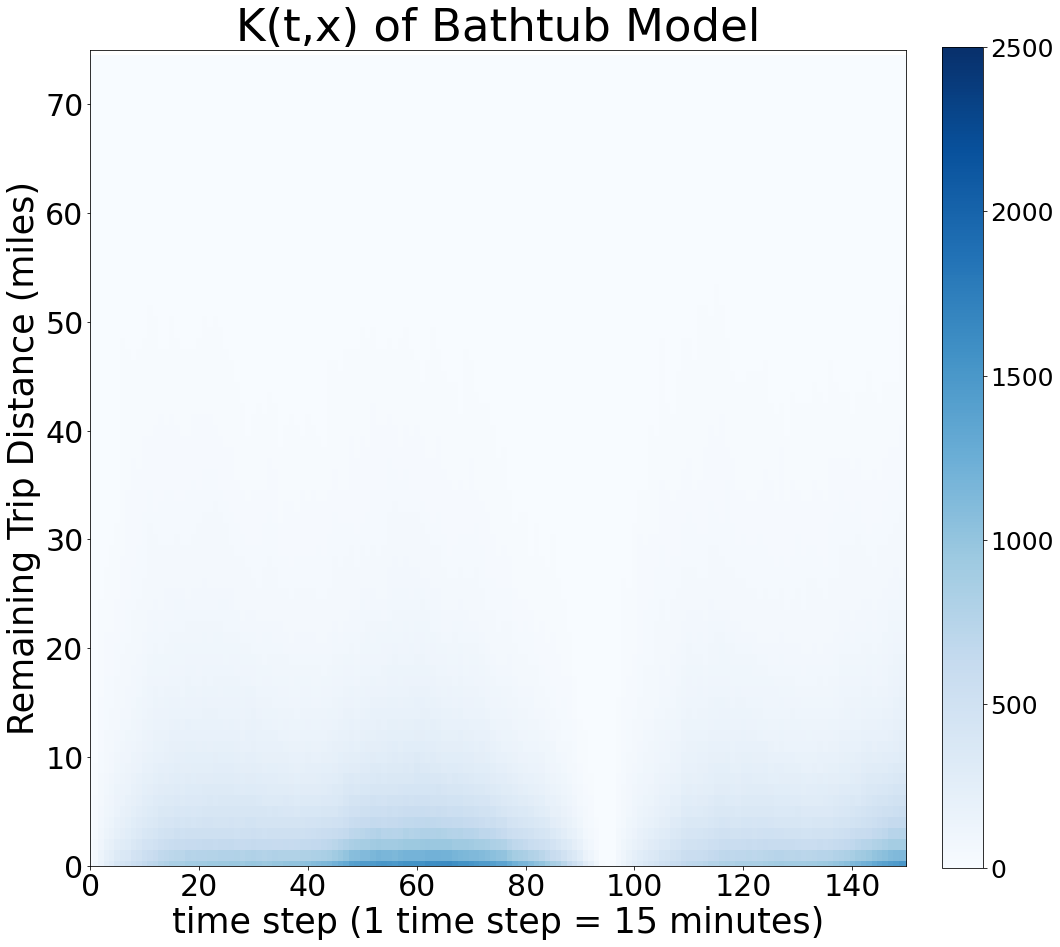

In [6]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,len(pi_real),0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [7]:
## Scale
N_timestep = 24*5*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  479
usol max =  1748


In [8]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  7200
N_u =  1440
N_f =  2880


In [9]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [10]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [11]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [12]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [13]:
X_u_train.shape

(1440, 2)

In [14]:
X_u_test.shape

(5760, 2)

In [15]:
X_u_train

array([[0.        , 0.7473904 ],
       [0.47297297, 0.76200418],
       [0.54054054, 0.2526096 ],
       ...,
       [0.2027027 , 0.61795407],
       [0.33783784, 0.18371608],
       [0.60810811, 0.01461378]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [16]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [17]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.011164986159991187 0.02033962336777451 0.0019903489522078645 0.8369534808892812
0.010773284261653214 0.020322367654862346 0.0012242008684440837 0.8343496850000603
0.010648301640182519 0.020258254009356085 0.0010383492710089536 0.8316120376807455
0.01047078638468371 0.019941726780017918 0.000999845989349501 0.8233261801888717
0.010104289544192362 0.019040612843468384 0.0011679662449163393 0.8011084967148325
0.00975350941078745 0.01809189878282158 0.0014151200387533202 0.7780987789608458
0.0095895056146359323 0.017684002652468032 0.0014950085768038344 0.768934643332029
0.0095395975962591188 0.01755534749647298 0.0015238476960452582 0.7664722121813305
0.0095015115535379384 0.017506937413658611 0.0014960856934172657 0.7658368519891484
0.0094199717621692835 0.017467279984541041 0.0013726635397975258 0.7657092729398857
0.009337835276154758 0.017466881616049187 0.0012087889362603285 0.7659891880143482
0.0092925794981285077 0.017465929434667085 0.0011192295615899295 0.7655137735411778
0.0092

0.00758288822266646 0.013636172198106493 0.0015296042472264268 0.6730561883088391
0.007582654665172734 0.013628336900327876 0.0015369724300175916 0.67288098132554
0.0075824318979854088 0.013624787493946459 0.0015400763020243582 0.6727653064856551
0.0075815518094773382 0.013630040941022771 0.0015330626779319048 0.6729395347180781
0.007580553120343678 0.013633324926276731 0.0015277813144106245 0.6730381616611236
0.0075785160946658311 0.013635303867742908 0.0015217283215887541 0.6730850933329777
0.0075781450252048969 0.01364552025774245 0.0015107697926673444 0.6733684538281394
0.007577451150737634 0.013627203527015332 0.0015276987744599366 0.6730009955298837
0.0075769392644255478 0.013591654834669188 0.0015622236941819083 0.6718184735852207
0.0075766668650255418 0.013607418043147176 0.0015459156869039065 0.6723950782696493
0.0075763944403677121 0.01360515303623387 0.0015476358445015543 0.6723124025353238
0.00757633742957994 0.013601402014345669 0.0015512728448142119 0.672234112770803
0.00

0.0075550114858925549 0.013541595537990831 0.0015684274337942788 0.670777794819361
0.0075549473062278081 0.013537527460690559 0.0015723671517650578 0.6707914949433752
0.0075548960541388169 0.013537366792478118 0.0015724253157995164 0.6707628294144976
0.0075548532921930721 0.013535895712070046 0.0015738108723160982 0.6707003356307826
0.0075547968165934109 0.013532482245951676 0.0015771113872351452 0.6706090832824617
0.007554753970902512 0.01353391550124175 0.0015755924405632747 0.6706644293172396
0.0075546703353299187 0.013534491014076853 0.0015748496565829841 0.67072593342872
0.00755463743477709 0.013533426673499606 0.0015758481960545729 0.6706616640988531
0.007554556200467911 0.013530028705418352 0.00157908369551747 0.6705568924479467
0.0075544609655255716 0.013535010188017482 0.0015739117430336616 0.670734140131986
0.0075544112610381933 0.013537458636556761 0.0015713638855196258 0.6707465455328356
0.0075543413364764613 0.013533291633768631 0.0015753910391842925 0.6705923594436426
0.0

0.0075510111520545658 0.01351830358935242 0.001583718714756712 0.6702942437063094
0.0075509565169576808 0.013523244734653507 0.0015786682992618541 0.6704330740685757
0.0075509294558169879 0.0135192683592076 0.0015825905524263749 0.67033447804074
0.0075509015224307537 0.013518950842208232 0.0015828522026532757 0.6703172093945289
0.0075508839401044513 0.013521593468701059 0.0015801744115078442 0.6703876997234701
0.007550866307090549 0.013524392969513424 0.0015773396446676731 0.6704739552393127
0.007550845817650048 0.013521953869464934 0.0015797377658351619 0.6704363302649866
0.0075508213082798566 0.013521061112653731 0.0015805815039059827 0.6703796084445965
0.0075508087041366483 0.013521419922859291 0.0015801974854140058 0.6703763493933883
0.0075508011179527927 0.013521277557066237 0.0015803246788393479 0.6703738878801974
0.0075507912780296777 0.013519502507663648 0.0015820800483957076 0.6703302833990715
0.0075507849361205861 0.013521952431614139 0.0015796174406270339 0.6703997162203886


0.0075464950717438152 0.013493439407523214 0.0015995507359644156 0.6698874050953737
0.0075463741495984445 0.01349391884348234 0.0015988294557145494 0.6698239984158023
0.0075462619211566651 0.013492007120814151 0.00160051672149918 0.6697948428127073
0.0075458347908890742 0.013491522380545016 0.0016001472012331321 0.6698384176015124
0.0075454062201175919 0.013479036061956424 0.0016117763782787595 0.6694611368983797
0.0075449027552565813 0.013521522040524387 0.0015682834699887753 0.6706848791626128
0.0075441975893365326 0.013501254810480822 0.0015871403681922427 0.670026370878538
0.0075438063460779988 0.013484718270021671 0.0016028944221343265 0.6696837301500829
0.00754344990113794 0.013474819450134628 0.0016120803521412518 0.6694055532502796
0.0075427285114636122 0.013476941789354477 0.0016085152335727473 0.6695353390826511
0.0075424096132540022 0.01348508638005551 0.001599732846452494 0.6696800456547575
0.0075421056571501263 0.013490002814406281 0.0015942084998939706 0.6699174693017599


0.0075065574464977776 0.013422625060737091 0.001590489832258464 0.6683320486500582
0.007505313256943689 0.013415279052950041 0.0015953474609373369 0.6683945441128185
0.0075040925627957427 0.013410200325454546 0.0015979848001369389 0.6685177311631689
0.0075035078074023286 0.013419126155766486 0.0015878894590381704 0.6688786570835843
0.0075032072790681067 0.01340045550552333 0.001605959052612884 0.6684392500604452
0.0075028687798207438 0.013400416498204211 0.0016053210614372776 0.6682873941207834
0.0075023283246380343 0.013395593938176641 0.0016090627110994279 0.6682220710366729
0.0075017700181197432 0.013383219977114291 0.0016203200591251952 0.6678757451349118
0.0075015616099565995 0.013384595988579035 0.0016185272313341643 0.6679870853987867
0.007501239864990618 0.013388530307497875 0.00161394942248336 0.6678890581222421
0.0075010404050246558 0.013391322770511674 0.0016107580395376374 0.6680446803232524
0.007500955551608548 0.01338172190256923 0.0016201892006478653 0.6676990887568728
0

0.0074936737123054422 0.013394631636862485 0.0015927157877483988 0.6680900278004561
0.0074935027312577375 0.013382679808957758 0.0016043256535577173 0.6678027270739929
0.0074934420148519733 0.01337809252651374 0.001608791503190207 0.6676462792699251
0.00749338786903795 0.013387034205177518 0.0015997415328983812 0.6679290245431858
0.0074932853495678579 0.013383803317947137 0.0016027673811885787 0.6677706178215822
0.0074932006573626237 0.01337250008558594 0.0016139012291393076 0.6674931203556583
0.0074931091752672378 0.013376336214660821 0.0016098821358736535 0.6675779107702107
0.0074930007942075882 0.013378109474867022 0.0016078921135481558 0.667645074283224
0.0074929260805133013 0.013380165471959195 0.0016056866890674073 0.6677669402310388
0.0074928208941142773 0.013381540015933653 0.0016041017722949011 0.6676856927110013
0.0074926967486845138 0.013372994308655276 0.0016123991887137515 0.6675554465797732
0.0074926513020467794 0.013379064072713377 0.0016062385313801823 0.667802042683929

0.0074905573502298609 0.01336987860262618 0.0016112360978335419 0.6674775212123751
0.0074905315076592384 0.013364082894550393 0.0016169801207680833 0.6673319162685201
0.0074905022821924305 0.013365503324460596 0.001615501239924265 0.6674261985654353
0.0074904691362573644 0.01336955330799686 0.0016113849645178694 0.6675112215055431
0.0074904482122256661 0.013367327777863879 0.0016135686465874521 0.6674407447429138
0.0074904361261838833 0.013372827581092775 0.0016080446712749921 0.6676021480746515
0.0074904132996038205 0.013368441275501535 0.0016123853237061064 0.6674964522196074
0.007490401765387897 0.013368312938768733 0.0016124905920070606 0.6674461406277167
0.0074903915592752952 0.013365292608085179 0.0016154905104654111 0.6673672370324673
0.0074903688836953607 0.013369223477760915 0.0016115142896298059 0.6674957839839384
0.0074903565095648487 0.013371051794951209 0.0016096612241784892 0.6675326351557622
0.0074903394870750872 0.013368446724398339 0.0016122322497518359 0.6674727006410

0.0074881965271731583 0.013358726064236714 0.0016176669901096028 0.6672742410364692
0.0074881935096362661 0.013359083871198739 0.0016173031480737937 0.6672818462487912
0.0074881885898680648 0.013359890089691925 0.0016164870900442041 0.6672983890832537
0.0074881791581775208 0.013360290093508616 0.0016160682228464249 0.6673079952408042
0.0074881457140509883 0.013362588823775997 0.0016137026043259802 0.6673690650353419
0.0074881087746699925 0.013363328341452894 0.001612889207887091 0.66738648645435
0.00748807172419731 0.013364679269156519 0.0016114641792381013 0.6674109247295579
0.0074880413423855218 0.013363741744444097 0.0016123409403269462 0.6674115055237442
0.00748800926147577 0.013360427938937209 0.0016155905840143326 0.6673472414622238
0.0074879844652573713 0.013362371432772914 0.0016135974977418283 0.6673868863928493
0.0074879563212295452 0.013362075221274234 0.0016138374211848562 0.6674404445498231
0.0074879277643172476 0.013358845580519432 0.0016170099481150632 0.6673353424568812

0.0074842600058427633 0.013352335867001328 0.0016161841446841975 0.6670082237318005
0.00748365692807415 0.013354278416549683 0.0016130354395986167 0.6670044478351823
0.0074834489506121968 0.013378257343040167 0.0015886405581842277 0.6676552589714819
0.0074832355351692409 0.013363354932256674 0.0016031161380818085 0.6672832424965449
0.0074830183322389362 0.013364569425558064 0.0016014672389198081 0.6673403220933899
0.0074829337170750163 0.013354322211675172 0.0016115452224748604 0.6669897950638601
0.0074828861293381559 0.013357219160753235 0.0016085530979230761 0.6671297018880571
0.0074827948101671149 0.013367958160415788 0.0015976314599184418 0.6674634339311406
0.00748271234564296 0.013355775286638467 0.0016096494046474532 0.6671304027214873
0.0074826005752188125 0.013359439187376407 0.0016057619630612183 0.6672110234665183
0.0074824729665021331 0.013358105802307844 0.0016068401306964224 0.6671954867979488
0.0074822754312008945 0.013359488760629605 0.001605062101772184 0.66722876100640

0.0073194012142712653 0.012969146456077175 0.0016696559724653564 0.6566744479583699
0.00731900916562298 0.012988502085287394 0.0016495162459585666 0.6563007848467015
0.0073168894605007972 0.01296769672701879 0.0016660821939828044 0.6561155135666825
0.0073157994960788382 0.012993052737155376 0.0016385462550022995 0.6571543570325226
0.0073148356085297305 0.012976706069931258 0.0016529651471282024 0.6564464578874017
0.0073142857297188923 0.012966450794585908 0.0016621206648518767 0.6561163185779749
0.0073135869151536173 0.012968243581328408 0.0016589302489788272 0.6560969677347154
0.0073129338686604194 0.012968767043687872 0.0016571006936329671 0.6562037452072409
0.0073122714323059041 0.012972745554928574 0.0016517973096832343 0.6564234470526915
0.0073115301480033978 0.012975020955488022 0.001648039340518774 0.6565924828404329
0.00731067020388207 0.012977876964933993 0.0016434634428301473 0.6567954990223427
0.0073097459756496655 0.012977931298279073 0.0016415606530202583 0.656814016156205

0.0072504476254975064 0.012908010510605498 0.0015928847403895148 0.6560462061277025
0.0072500344610639507 0.012900428196656996 0.0015996407254709045 0.6558007456875783
0.0072496578618308181 0.012921742027971646 0.0015775736956899905 0.6565056465535218
0.0072490632273868906 0.012902605548103185 0.001595520906670596 0.6557447281640278
0.0072488186774757766 0.012898130507468807 0.0015995068474827464 0.6555874961300028
0.0072486601597645953 0.012905299275361532 0.0015920210441676577 0.6559403770285994
0.0072481973658212661 0.0129049493607395 0.0015914453709030328 0.6558824122525465
0.0072479897299745936 0.012910350296600851 0.0015856291633483371 0.6558913935448908
0.0072476476939741553 0.012904041183590384 0.0015912542043579269 0.655736321425561
0.0072474835262816882 0.012905163771411857 0.0015898032811515188 0.6559440702750736
0.0072473515730515229 0.012910589866032959 0.0015841132800700872 0.6559174470927109
0.00724723585020326 0.012912180864083522 0.0015822908363229966 0.656004950275192

0.007191048860693031 0.012817613142317184 0.0015644845790688776 0.6540196649194039
0.0071907854252659508 0.012815489609714816 0.0015660812408170859 0.6540184400179666
0.0071904578846603189 0.012820313890760425 0.0015606018785602124 0.6541681751185368
0.0071903035111079115 0.012799184327162275 0.0015814226950535476 0.6534684830140325
0.0071897863555174515 0.012805008996229543 0.0015745637148053598 0.6537456923612072
0.0071895060905182761 0.012813241856934618 0.0015657703241019334 0.6539933701239934
0.0071892181434371 0.012808729157370793 0.0015697071295034057 0.653878150288956
0.007188881076708291 0.012812323181192185 0.0015654389722243966 0.6538625737231264
0.007188425618588761 0.012819973937010164 0.0015568773001673577 0.6542005817428692
0.0071881969789997875 0.012816745997391093 0.0015596479606084818 0.6540978390767846
0.0071880654381907272 0.012819265502427513 0.0015568653739539415 0.654217953018719
0.0071878262143028285 0.012816880233206963 0.0015587721953986946 0.65422819434318
0.

0.0071159290399521067 0.012654497928659938 0.0015773601512442761 0.6520243545385217
0.0071131214654103518 0.012647430207835958 0.0015788127229847463 0.6522840818871742
0.0071117679054632215 0.01267682202593565 0.0015467137849907923 0.6527520359193612
0.00711023978322641 0.01267030223977221 0.001550177326680609 0.6525180928972946
0.0071096923601376089 0.012659948938027476 0.0015594357822477415 0.6522802968073931
0.007109058295892012 0.012684702810275802 0.0015334137815082222 0.6532422137278711
0.0071082345801292343 0.01269459204222315 0.0015218771180353198 0.6534273231422145
0.0071078812752697939 0.01269042808677159 0.0015253344637679972 0.653344617789916
0.0071072986026242124 0.0126903628429634 0.0015242343622850246 0.6532718851470013
0.0071063419338612162 0.012679204284968815 0.0015334795827536168 0.6530768647920155
0.007104767632091228 0.012666042786647723 0.0015434924775347321 0.6528266128671398
0.0071037475659851881 0.012659929701601522 0.0015475654303688539 0.6526358893600892
0.00

0.0069801360959686606 0.012515585289249355 0.0014446869026879668 0.6531957115589431
0.0069776249842299666 0.012503133141903735 0.0014521168265561979 0.6526254774953145
0.0069757597069084343 0.012504635870016934 0.0014468835437999351 0.6525407832422183
0.0069743698260462334 0.012509837428002112 0.0014389022240903551 0.6524269957302009
0.0069730902592284229 0.012525453817055535 0.0014207267014013105 0.6530279250077831
0.0069711952418812645 0.012507757465655694 0.0014346330181068342 0.6528408695286091
0.0069693272535306262 0.012512505145124446 0.0014261493619368076 0.6530585234119495
0.0069678487021951228 0.012521921684714056 0.0014137757196761899 0.6533866410772113
0.0069670649809934343 0.012524432465293615 0.0014096974966932537 0.6535314963511449
0.0069651947832737654 0.012535768803761088 0.001394620762786443 0.6540111462885364
0.0069636974123508813 0.012534497491941583 0.0013928973327601798 0.6538773024768387
0.0069621914920884173 0.012530699731568607 0.0013936832526082281 0.6537830435

0.0068507771962359205 0.012415097476331701 0.0012864569161401404 0.658138555013689
0.0068499141665269974 0.012401777303792707 0.0012980510292612882 0.6581754576957436
0.0068495826485325713 0.012397452274720843 0.0013017130223442991 0.6583201165726257
0.00684926566565278 0.012391410832664661 0.0013071204986408983 0.6583562368683528
0.0068488791617234441 0.012387390041141123 0.0013103682823057655 0.658341063557695
0.0068484183993756586 0.012386326492420776 0.0013105103063305412 0.6582805546142189
0.0068478286469898387 0.012387385677882912 0.0013082716160967645 0.6582235705470443
0.0068473552828534571 0.012386464624430858 0.0013082459412760575 0.6579146176996533
0.0068469306572653613 0.012391538605595248 0.0013023227089354746 0.6578826936991189
0.0068464894764574524 0.012388195645901766 0.001304783307013139 0.6576852470405337
0.0068458034258208327 0.012383797893467306 0.00130780895817436 0.6575301263138584
0.0068454141215462967 0.012378595641212227 0.0013122326018803658 0.657499627258338


0.0068129581969016513 0.012276055905582601 0.0013498604882207011 0.6578209689268304
0.0068127171624723587 0.012262578091760609 0.0013628562331841078 0.6574816840833557
0.0068122573703846339 0.012270638222636469 0.0013538765181327992 0.6576646315183466
0.0068118671299960271 0.01227079159392213 0.0013529426660699249 0.6577364410376808
0.0068115270510901915 0.012263545294907937 0.0013595088072724457 0.6575965541436528
0.0068112520206873358 0.012255415351682968 0.0013670886896917033 0.6573638010076406
0.006810942100772592 0.012252997920178954 0.0013688862813662312 0.6574081633374855
0.00681054182145674 0.012250613891880733 0.0013704697510327471 0.6575832417218336
0.0068102059411695778 0.012251317645416145 0.0013690942369230096 0.6575735453465519
0.0068098092454087636 0.012243746660192177 0.0013758718306253511 0.6575845630827669
0.0068094541861280014 0.012247402879257595 0.0013715054929984089 0.6574626442650321
0.0068092252207773664 0.012248640977602955 0.0013698094639517774 0.6571214581346

0.0067860752894663909 0.012260585033983517 0.0013115655449492654 0.6609682863080422
0.0067858547841642865 0.012256261045186703 0.00131544852314187 0.6609133159313492
0.0067855988663730951 0.012251409642789247 0.0013197880899569439 0.6608686729151965
0.0067852464455380786 0.012256842924693166 0.0013136499663829915 0.6611303317554195
0.0067849855691548252 0.012245750165447326 0.0013242209728623246 0.6611503287053203
0.0067847590999862983 0.012254457551734167 0.0013150606482384298 0.6614603202867493
0.00678460670621211 0.012258935254504343 0.001310278157919876 0.6615532702920864
0.0067845043372255056 0.012257598374810384 0.0013114102996406268 0.6615899089789756
0.0067844289990842844 0.012258788453731542 0.0013100695444370277 0.661531946425953
0.0067843845681836452 0.012257546218545134 0.0013112229178221556 0.6614089987384801
0.0067843279403745705 0.012255955770584097 0.0013127001101650437 0.6613879688382962
0.0067842556394931575 0.012255175501423856 0.0013133357775624603 0.661410229847465

0.0067636833878338791 0.012213128107151706 0.001314238668516053 0.6615187173751053
0.0067634521376875251 0.012206202060356591 0.001320702215018459 0.6615080976599977
0.0067632050899703224 0.012208984572154071 0.0013174256077865736 0.6618234557253491
0.0067630448459305732 0.012208166093652724 0.0013179235982084217 0.6617451527923213
0.006762846108928796 0.012204728933526128 0.0013209632843314651 0.6614739935423818
0.0067626055563360585 0.012206846916443507 0.0013183641962286098 0.6613801652172376
0.0067622865954960034 0.012207782455798372 0.0013167907351936358 0.6612335023061261
0.0067618731545886586 0.012212766778017 0.0013109795311603172 0.6612420784293265
0.0067616390923772186 0.012206968894351479 0.0013163092904029583 0.6609863916039397
0.006761433497839483 0.012209066887081661 0.0013138001085973054 0.6610563522027204
0.0067612732819129148 0.012206751569931252 0.0013157949938945772 0.6610390730168058
0.0067610864704804163 0.012204582570109713 0.0013175903708511196 0.6610677092637994

0.0067421911701794606 0.012152392286723828 0.0013319900536350922 0.6603350875529254
0.0067419871480673714 0.012155603388545568 0.0013283709075891748 0.6604101002049231
0.0067418003682437333 0.012157939987206868 0.0013256607492805978 0.6603996599104295
0.006741648780856666 0.012162161913173437 0.0013211356485398949 0.660406716588522
0.0067415089722832637 0.012161978868551269 0.0013210390760152581 0.6602871588169995
0.0067413366961358041 0.012162427010563331 0.0013202463817082763 0.6602383488463507
0.00674108558286378 0.012161605066723293 0.0013205660990042673 0.6601802459014656
0.0067406718682256226 0.012163293925506431 0.0013180498109448152 0.6602563198937574
0.0067403404990284879 0.012165518722435185 0.00131516227562179 0.6602996968701874
0.0067401112249913511 0.012169945990858603 0.0013102764591240996 0.6604913700247849
0.0067398992388804108 0.012168198701570062 0.0013115997761907585 0.6603795784098143
0.0067396621907658211 0.01216759581664305 0.0013117285648885919 0.6603194660947341

0.0067231493864381049 0.012114228068657695 0.0013320707042185148 0.6597486169786416
0.0067229624176384879 0.012110601370782244 0.0013353234644947318 0.6597898217590377
0.0067225588702739319 0.012109655325535366 0.0013354624150124976 0.6601673361415875
0.0067223065404648907 0.012111353377314399 0.0013332597036153835 0.6600256083105213
0.0067220756228209538 0.012101561247681861 0.0013425899979600453 0.6601660478885515
0.0067213842133752736 0.01212227576786274 0.0013204926588878071 0.6604689341531613
0.0067210215445141705 0.012128058896734097 0.0013139841922942433 0.6603229025083532
0.0067204583383373047 0.012124346204776343 0.0013165704718982657 0.6599099422719451
0.0067200973945860205 0.012117764430623894 0.0013224303585481479 0.6599761400314186
0.0067197257822441741 0.012113086696864103 0.0013263648676242448 0.6598482087363139
0.0067193727960563566 0.012120768993146753 0.0013179765989659602 0.6601936824729209
0.0067189516646268153 0.012111962106283975 0.0013259412229696555 0.6605247943

0.0066936030676867167 0.012088186757447723 0.00129901937792571 0.6594282600082302
0.0066933526560792557 0.012083627129501413 0.0013030781826570983 0.6592077707415075
0.0066931171310992974 0.012079993921945448 0.0013062403402531468 0.6590671172204926
0.0066929482982308452 0.012078959451755982 0.0013069371447057086 0.6590507933381637
0.006692807544341991 0.012079401789559263 0.0013062132991247186 0.6589953309581205
0.00669268851523419 0.012080014951912963 0.0013053620785554165 0.6590048788628816
0.0066925753447153753 0.012080732471300652 0.0013044182181300992 0.6589602918021129
0.0066925033376402463 0.012077305248985693 0.0013077014262947997 0.6587955665980503
0.0066924334618966592 0.012075600599854417 0.0013092663239389019 0.6586626762066342
0.00669238782509227 0.012073938936737803 0.0013108367134467376 0.6585557385687554
0.0066923255709459345 0.012075598692184407 0.0013090524497074622 0.6585897888837406
0.0066922579305351195 0.012075010485567144 0.0013095053755030951 0.6586391260741492

0.00668304425004186 0.0120676852952526 0.0012984032048311198 0.6617501112472758
0.006682983297381641 0.012067467119530054 0.0012984994752332276 0.6617235090867131
0.00668290342533014 0.012067172943723265 0.001298633906937014 0.6616677454063525
0.0066828357368672641 0.012067326534242223 0.0012983449394923048 0.6615776257264325
0.006682779002932078 0.012068940254165437 0.001296617751698719 0.6616099612896352
0.0066827421898926461 0.012068409443377724 0.0012970749364075681 0.6615723849139075
0.0066827010019403655 0.012068673002567183 0.0012967290013135475 0.6615500272056754
0.0066826659166737421 0.012067333020451808 0.0012979988128956762 0.6615042055993554
0.0066826329847503758 0.012065790318609378 0.0012994756508913727 0.6614875225720481
0.0066826091106104435 0.012064872556605167 0.0013003456646157206 0.6614725883752279
0.0066825890262651785 0.012064331156901824 0.0013008468956285325 0.6614755925575507
0.006682555779687324 0.012064131528029876 0.0013009800313447718 0.661499988475554
0.00

0.0066768611019250275 0.012048663454272093 0.0013050587495779624 0.6611792330265173
0.0066767586289798392 0.012049916041873244 0.0013036012160864345 0.6611679297364328
0.0066766670475714223 0.012055813073578451 0.0012975210215643938 0.6612050050221666
0.00667653895512561 0.012054976442570054 0.001298101467681166 0.6613427174901644
0.006676454915742017 0.012052476423563411 0.0013004334079206228 0.6614579591781191
0.0066763675755720162 0.012052454441759284 0.0013002807093847482 0.661432888824432
0.0066762468448360113 0.012056457560387845 0.0012960361292841775 0.6615332180848215
0.0066761998908743273 0.012056835018132848 0.0012955647636158072 0.6615846711686367
0.0066761143917061418 0.012057147168613171 0.0012950816147991129 0.6616575365403295
0.0066759983762953966 0.012056186575525223 0.0012958101770655702 0.6616799664370464
0.0066758887421872123 0.012053534304198853 0.0012982431801755714 0.6616322129724193
0.0066757729993338058 0.012053142359437051 0.0012984036392305605 0.66163586453674

0.0066690093204072026 0.012045068358909375 0.00129295028190503 0.6615232467565219
0.0066689703327206086 0.012044196594223018 0.0012937440712181985 0.6615515158237042
0.0066689289611318453 0.012043271587711008 0.0012945863345526832 0.6616055317279699
0.0066688788661840755 0.012044219346097855 0.0012935383862702962 0.6616497520684641
0.0066688437437591877 0.012043428642849616 0.0012942588446687602 0.6616813332940938
0.0066688151470954892 0.012044336156108903 0.0012932941380820763 0.66165284246678
0.0066687803647234971 0.012045034037022711 0.0012925266924242833 0.661638780657129
0.0066687199983093077 0.01204520047157792 0.001292239525040696 0.6616098154409432
0.0066686640799936961 0.012044170946642013 0.0012931572133453788 0.6615356912518273
0.0066686030049427922 0.012042624814542924 0.0012945811953426602 0.6614803941484463
0.0066685795204864881 0.012044248946459711 0.0012929100945132657 0.6616071958733217
0.0066685582138168477 0.012043071514411845 0.0012940449132218493 0.6616036055346362

0.0066662873080565073 0.012033298368228003 0.0012992762478850122 0.6623646643485038
0.006666270144124551 0.012033353882628313 0.0012991864056207886 0.6623259404216365
0.0066662527392482764 0.012033222155049123 0.001299283323447431 0.662313044435823
0.0066662241165272489 0.012032985735600445 0.0012994624974540531 0.6622907985168699
0.0066662157936811213 0.012032197590236103 0.0013002339971261402 0.6622915942738778
0.00666619036406211 0.012032269007848959 0.0013001117202752605 0.6622985501566059
0.0066661675254558045 0.012031930424303562 0.0013004046266080463 0.6622602296916027
0.0066661529974242715 0.012031375071281467 0.0013009309235670749 0.6622196116820298
0.0066661330241245638 0.012032204491898553 0.0013000615563505756 0.6621968885780382
0.006666107543502095 0.012031787607554481 0.0013004274794497094 0.6621899340557387
0.0066660576947662883 0.012030633389697653 0.0013014819998349236 0.6621534988618546
0.0066660346462629749 0.012030460880997832 0.0013016084115281177 0.662173965950927

0.0066626590112035863 0.012012457108650672 0.0013128609137564994 0.6614818241055934
0.00666258443247605 0.012011614760797193 0.0013135541041549067 0.661490763082553
0.0066625287973286528 0.012012166960379749 0.0013128906342775571 0.6615535944486156
0.0066624429715695091 0.012014262822175976 0.0013106231209630418 0.661718223972633
0.0066623835106129851 0.012015897898624948 0.0013088691226010227 0.6617535404186641
0.006662358140259902 0.012018510409357096 0.0013062058711627079 0.6617964781373343
0.0066622977736473608 0.012019585890700875 0.0013050096565938455 0.6617577232806938
0.0066622735133810519 0.012019920509185697 0.0013046265175764063 0.6617144518837531
0.0066622462267689839 0.012019967618856044 0.0013045248346819243 0.6616610705100169
0.0066622172925534413 0.012022704703213382 0.0013017298818935011 0.6617475979547375
0.006662183781420191 0.012023123794390031 0.0013012437684503512 0.6617772506334905
0.0066621304636099834 0.012024053177300736 0.0013002077499192305 0.661834141567109

0.0066611533178532042 0.012019598196757195 0.0013027084389492139 0.662207877449294
0.00666111106135293 0.012020054611545644 0.0013021675111602154 0.662153149986183
0.0066610614270622669 0.012020552167126008 0.0013015706869985259 0.6621591897417869
0.0066610406330005652 0.012020659043726716 0.0013014222222744146 0.6621487504720203
0.0066610017642703152 0.012021141820104357 0.0013008617084362731 0.6621703481036528
0.0066609595259350691 0.012021993588418951 0.0012999254634511882 0.6622157976495112
0.0066609413379644274 0.012022713306506772 0.0012991693694220834 0.6621623843626021
0.00666091249792544 0.012023001050613989 0.001298823945236892 0.6620767245913726
0.0066608828792784616 0.01202357749198471 0.0012981882665722133 0.662056727894022
0.00666086158663267 0.012024707647611946 0.001297015525653395 0.6621276118090812
0.0066608405081738115 0.012026049770146523 0.0012956312462010997 0.6621481050451167
0.006660804222878079 0.012026375331420607 0.0012952331143355515 0.6621213291559367
0.006

0.006659833256062047 0.012027588232645001 0.0012920782794790932 0.6623641085701464
0.0066597998849533572 0.012028259695294787 0.0012913400746119277 0.6623226096639836
0.0066597768935669627 0.012026192806464837 0.0012933609806690877 0.6622230375993995
0.00665977209204601 0.012025911710600705 0.0012936324734913144 0.6622217423794627
0.0066597511889725427 0.01202527644151255 0.0012942259364325344 0.6622120181930679
0.0066597332922255651 0.012025186822007723 0.0012942797624434074 0.6621791573047094
0.0066597131944763251 0.01202543430558769 0.0012939920833649598 0.662174017638981
0.0066596933624660064 0.012025808095805236 0.0012935786291267764 0.6621646478350123
0.0066596552629796151 0.012026502316680298 0.001292808209278932 0.6621604513570966
0.0066595977356259549 0.012027387242470751 0.0012918082287811591 0.6622009922615335
0.0066595766167192082 0.012027613524585144 0.0012915397088532721 0.6622244941262255
0.0066595230963559168 0.01202728433100226 0.0012917618617095735 0.6622953953930016


0.0066574153807490493 0.012019123437922307 0.0012957073235757915 0.6626009700920552
0.0066574102262938672 0.012018972675299102 0.0012958477772886316 0.6626165648331876
0.0066574060415646591 0.012019077607828702 0.0012957344753006163 0.6626233658268673
0.0066573957507637151 0.012019343652997066 0.0012954478485303639 0.6626365393990598
0.0066573822561602023 0.01201989658073576 0.0012948679315846435 0.6626422285136484
0.0066573645424006815 0.012020628995778004 0.0012941000890233588 0.6626521639307889
0.0066573536492995451 0.012022204087328932 0.001292503211270158 0.6626431737799672
0.006657331620652151 0.012023980198807599 0.0012906830424967027 0.6626971492403146
0.0066573062491734345 0.012023513804878429 0.0012910986934684403 0.6627041197160827
0.006657259615373892 0.012023424940292567 0.0012910942904552163 0.6627073750169596
0.0066572351586688082 0.012024078283266057 0.0012903920340715587 0.6628208889528486
0.0066571878701716979 0.012025273650467322 0.0012891020898760739 0.6627723496372

0.0066545228741219375 0.012016438965067291 0.0012926067831765839 0.6631413547959946
0.0066545132094763849 0.012016698530360945 0.0012923278885918236 0.6631808473053811
0.0066545054222333245 0.012016520993467884 0.0012924898509987649 0.6632127195803454
0.00665449214449404 0.012015789701760093 0.0012931945872279864 0.6632517979747417
0.0066544817023465978 0.012015181320529401 0.0012937820841637947 0.6632645458927107
0.0066544694326376745 0.012014932702485671 0.0012940061627896783 0.6632839134601066
0.0066544644143567222 0.012014532687363131 0.0012943961413503134 0.6632688847812559
0.0066544602449829593 0.012014048066310125 0.0012948724236557933 0.6632200446042198
0.0066544503444232964 0.01201489731098649 0.0012940033778601023 0.6632465138539809
0.0066544444149728424 0.012015617146315098 0.0012932716836305861 0.6632714688673979
0.006654437894385099 0.012015488527261139 0.001293387261509059 0.6632693263615046
0.00665442235524335 0.012015336689318873 0.001293508021167826 0.663282965203878
0

0.0066534187469452786 0.012014352868884422 0.0012924846250061352 0.6658269460878375
0.0066534184290520087 0.012014382082990478 0.0012924547751135397 0.665828871001413
0.006653414196590479 0.012014012033276145 0.0012928163599048132 0.6658154018125357
0.0066534104573760123 0.012013448201627946 0.0012933727131240779 0.6658415110186001
0.0066534087883404879 0.012013028588996871 0.0012937889876841052 0.665798315009302
0.0066534011977027749 0.012012602696509353 0.0012941996988961966 0.6658114074941659
0.0066533963595175657 0.012013202964654784 0.0012935897543803474 0.665822009659715
0.0066533924935299115 0.012013955522024677 0.0012928294650351459 0.665808325523014
0.0066533895787594336 0.012014094043685919 0.0012926851138329489 0.6658038600967608
0.0066533846760333283 0.01201419506558846 0.0012925742864781974 0.6658003758121397
0.0066533820229016018 0.012014416255474697 0.0012923477903285063 0.6658142252139653
0.0066533810527039088 0.012014483674962636 0.0012922784304451815 0.665813884427243

0.0066512815733600992 0.012004470404033692 0.0012980927426865059 0.6654783602773361
0.0066512566194992006 0.012004548922930661 0.0012979643160677394 0.6654574620389169
0.0066512310479359621 0.012004974637392123 0.0012974874584798009 0.6654102140815625
0.0066512052532468257 0.012005954233246054 0.0012964562732475978 0.6653499835203651
0.0066511734450879706 0.012005701205930726 0.0012966456842452157 0.6652080016131316
0.0066511505919563231 0.01200522935769557 0.0012970718262170753 0.6651067853370275
0.0066511263454576523 0.012003253376292232 0.0012989993146230723 0.6650719058050578
0.0066511047567184324 0.012000261718145921 0.0013019477952909446 0.665076928525834
0.0066510847258917745 0.012000464333207016 0.0013017051185765321 0.6651715954346821
0.0066510665113881148 0.012001715636413295 0.0013004173863629344 0.6651996915509073
0.0066510536638278838 0.012002886655391053 0.0012992206722647151 0.6651935462067496
0.0066510466695276667 0.012004298218714422 0.001297795120340912 0.665163484117

0.0066502869863002941 0.012003406441650597 0.0012971675309499907 0.6655292007929361
0.0066502812394207411 0.012003302123709496 0.0012972603551319861 0.6656019694115196
0.0066502719509581665 0.012002420069089989 0.0012981238328263437 0.6655717168214238
0.006650249329103906 0.012001522694876322 0.0012989759633314905 0.6655765764142636
0.006650224780410479 0.01199987664482414 0.001300572915996819 0.6655598686829695
0.0066501977652093135 0.011999675149819157 0.0013007203805994697 0.6655756027039119
0.0066501705703510931 0.011999697431721934 0.0013006437089802523 0.6655334465646671
0.0066501444295862773 0.01200031269723177 0.0012999761619407843 0.6655210497420793
0.0066501307694306925 0.012000859488211935 0.0012994020506494491 0.6655097097760981
0.0066501130783087788 0.012001112099692996 0.0012991140569245619 0.6655264456499145
0.00665008871554372 0.012002009546531446 0.0012981678845559945 0.6655344371755857
0.006650062633897889 0.012001208902900596 0.0012989163648951833 0.6654389659979882


0.0066486925613834 0.011999394056295319 0.0012979910664714805 0.6647202022391465
0.0066486853267423117 0.012000050635220635 0.0012973200182639889 0.6647586870495049
0.0066486776742881873 0.012000407047012634 0.0012969483015637408 0.66478673730305
0.0066486655697328215 0.012001179683317348 0.0012961514561482946 0.6648379425048639
0.0066486578957697749 0.012002011049509001 0.0012953047420305491 0.6648837302090733
0.0066486549760490839 0.012002122867876065 0.0012951870842221021 0.6649009388315676
0.0066486521704942018 0.012001877606730457 0.0012954267342579458 0.6648840668079832
0.006648646487312759 0.012001130151915904 0.0012961628227096131 0.6648333813560187
0.006648630286423385 0.012001160433556344 0.0012961001392904265 0.6648369512663945
0.0066485973826356246 0.012000535966330692 0.0012966587989405576 0.6647914069624783
0.0066485949323466112 0.011999706929899477 0.0012974829347937452 0.6646925460878894
0.0066485400001482274 0.012000470114349794 0.0012966098859466602 0.6647356828362526

0.0066455015012259365 0.01199873854666198 0.0012922644557898926 0.6636384848962608
0.0066455000164705284 0.011998984937102551 0.0012920150958385058 0.6636377177435797
0.0066454976059234783 0.011999314595096996 0.0012916806167499605 0.6636327943195647
0.0066454946054028581 0.011999489798049027 0.0012914994127566893 0.6636404031567026
0.0066454897910713292 0.012000232257174896 0.0012907473249677635 0.6636800142505392
0.0066454894603249519 0.012000076293011967 0.0012909026276379371 0.6636672153295683
0.0066454865372277848 0.012000406462001317 0.0012905666124542528 0.6636818084413887
0.0066454818550468484 0.012000676591132591 0.0012902871189611055 0.6636865321720784
0.0066454780681997182 0.012000672632427292 0.0012902835039721441 0.6636774949277392
0.0066454606188153841 0.012000497262263885 0.0012904239753668838 0.6636705758970555
0.0066454363719157345 0.011999669898384203 0.0012912028454472658 0.6636601183025046
0.0066454338857217772 0.011998832936595235 0.0012920348348483197 0.6636549626

0.0066448645092258328 0.01199709035458873 0.001292638663862936 0.6647900042208855
0.006644861237218606 0.011997168781729224 0.0012925536927079879 0.6647822482937391
0.0066448595033127434 0.011997101771974359 0.0012926172346511273 0.6647828887466314
0.00664485601568085 0.011997109703516773 0.001292602327844926 0.6647889533891839
0.0066448539976870493 0.01199718688748082 0.0012925211078932794 0.6648025584183818
0.0066448509077810958 0.011997336595239098 0.0012923652203230942 0.6648219636137188
0.0066448481678507082 0.01199748831851778 0.0012922080171836367 0.6648530915572471
0.00664484448375964 0.011997676214364048 0.0012920127531552336 0.6648744804430311
0.0066448412089379341 0.011997647539047253 0.0012920348788286152 0.6648920095645334
0.0066448371893717325 0.011997676575613762 0.0012919978031297025 0.6648739884110659
0.0066448333254675689 0.011997586483123851 0.0012920801678112865 0.6648461094174425
0.0066448291967209716 0.011997816487589873 0.0012918419058520708 0.6648076548034352
0.

0.0066440583509300146 0.011993822025717211 0.0012942946761428187 0.6649787789046453
0.0066440396329106588 0.011993053258361646 0.0012950260074596704 0.6650004383478998
0.0066440311535004327 0.011992897341968753 0.0012951649650321121 0.6649945597727102
0.0066440297614752605 0.011992694152535097 0.001295365370415424 0.6649950363231051
0.0066440197138492429 0.011993116661666544 0.0012949227660319421 0.6649484559852346
0.0066440147168340159 0.011994407322171526 0.0012936221114965053 0.6649191860488174
0.006644005403880565 0.011994776777839059 0.001293234029922071 0.6648963606255511
0.0066439993548124132 0.011995225639740235 0.0012927730698845926 0.6648788053076093
0.006643995289164692 0.01199602049588277 0.0012919700824466133 0.6648558434657216
0.006643992993689252 0.011996763483372435 0.0012912225040060687 0.6648662157563126
0.0066439829460389239 0.011996843146181588 0.0012911227458962608 0.6648754439392811
0.0066439561345221932 0.011997143606234996 0.0012907686628093897 0.664857924014806

0.00664179390669232 0.011990573716290269 0.0012930140970943717 0.6618100938249347
0.0066417812485752457 0.011991055053137129 0.0012925074440133632 0.6617799615767033
0.0066417779146688248 0.011990554083670491 0.0012930017456671576 0.6617787691558888
0.0066417685502338005 0.01199007419555417 0.0012934629049134313 0.6617864695414802
0.006641762289833107 0.011990558071463958 0.0012929665082022563 0.6618008135993095
0.00664175209926026 0.011990982918718408 0.001292521279802111 0.6616844544903002
0.00664173637109948 0.011989914672569386 0.0012935580696295738 0.661663702828828
0.0066417218816659865 0.011989520902051741 0.0012939228612802317 0.6616727426562949
0.0066417113237928725 0.011989699652664628 0.001293722994921117 0.6616960457767179
0.0066416997548259049 0.011989614732052782 0.0012937847775990278 0.6616801234883423
0.0066416839471743769 0.011989746078216233 0.0012936218161325216 0.6616893588605914
0.00664167305111983 0.011989810183798452 0.0012935359184412078 0.6616646428446815
0.006

0.0066406052595733844 0.011982944939440731 0.0012982655797060391 0.6619008333693783
0.0066405929934922571 0.01198338329569773 0.0012978026912867844 0.6618856435713566
0.0066405777243725966 0.011983140251709464 0.0012980151970357287 0.6618422305389192
0.0066405732630869527 0.011982358457804394 0.001298788068369512 0.6618335671508458
0.0066405629455390863 0.01198179432009382 0.0012993315709843526 0.6618157593729791
0.006640554475189556 0.01198179938881248 0.0012993095615666326 0.6618458968703088
0.0066405407296056427 0.011981387057588907 0.0012996944016223776 0.6619011148203424
0.0066405327596743783 0.011981675867537815 0.001299389651810942 0.6619427791207659
0.0066405217723038553 0.01198143410595087 0.00129960943865684 0.6619504934592533
0.0066405080573536911 0.01198092932394673 0.0013000867907606518 0.6619078659912222
0.0066405065209951359 0.01198125931597609 0.0012997537260141811 0.661935942980881
0.0066404975152459245 0.011980900333075644 0.0013000946974162039 0.6618853967555527
0.00

0.006640075649813156 0.011981285386116964 0.0012988659135093473 0.6618283139914076
0.0066400698853909187 0.011980803070885473 0.0012993366998963651 0.661803783267909
0.0066400642189991194 0.011980390960717298 0.0012997374772809407 0.661767828527319
0.0066400602402945453 0.01197959834191155 0.0013005221386775403 0.6617294666922101
0.0066400533659860105 0.011979727189138343 0.0013003795428336786 0.6617227594132107
0.0066400459708467544 0.011979601015914765 0.0013004909257787441 0.6617401440451532
0.0066400347580327047 0.011980012470047145 0.0013000570460182635 0.661828460815982
0.0066400261784037686 0.011980020674679586 0.0013000316821279514 0.6618596806833459
0.0066400166082459487 0.011979361018639908 0.0013006721978519901 0.6618371443858543
0.0066400073339904549 0.011978662747388669 0.0013013519205922407 0.6618575307770038
0.0066400024013791468 0.011979170736568305 0.0013008340661899887 0.6618842070211615
0.0066399980626511233 0.011978925734712669 0.0013010703905895768 0.66190937127631

0.0066363995833828284 0.011970714167208239 0.0013020849995574175 0.6625726164235417
0.00663637071582791 0.011970508589256032 0.0013022328423997875 0.6625996040635637
0.0066363468296269674 0.011970331073011783 0.0013023625862421521 0.6626148879944308
0.006636323679090398 0.011970307607917462 0.0013023397502633339 0.6625911731759615
0.0066363032728598533 0.011969279573885714 0.0013033269718339925 0.6625085017059056
0.0066362844514585 0.011968679312445326 0.0013038895904716749 0.6624870247197443
0.0066362693912548065 0.011967898138557498 0.0013046406439521142 0.6624618970133227
0.0066362560117841788 0.011967827497348038 0.0013046845262203192 0.6624562156732298
0.00663624597366328 0.011968455309829252 0.0013040366374973088 0.6624876813231872
0.0066362346169042945 0.011968632182469179 0.0013038370513394114 0.6624881125948533
0.0066362330527187227 0.011968361687332892 0.0013041044181045533 0.6624670487238697
0.0066362278426632861 0.01196907183713769 0.0013033838481888815 0.6624497793642881
0

0.0066350051606122278 0.011958252980680328 0.001311757340544127 0.6622493296071877
0.0066350003813550979 0.011957644156435774 0.0013123566062744226 0.6622446628888409
0.0066349954037414095 0.011957420244471136 0.0013125705630116823 0.6622554292468165
0.006634990071483304 0.011957048874019108 0.0013129312689475002 0.6622366140022117
0.0066349832150160576 0.011956836804250257 0.001313129625781859 0.6622086224223023
0.006634982959833665 0.011957101846666 0.0013128640730013285 0.6622238157118167
0.0066349720880553176 0.011956703293629214 0.0013132408824814224 0.6621564722141987
0.0066349674788294564 0.011956944416157533 0.0013129905415013795 0.6621621857425565
0.0066349597694812688 0.011956934164629425 0.0013129853743331125 0.6621634781030015
0.0066349513184344178 0.011957448525193414 0.001312454111675422 0.6622306027227084
0.0066349451622278672 0.011957089002913934 0.0013128013215418012 0.6622011225396167
0.0066349369705998281 0.011957137640298352 0.0013127363009013046 0.6621774711693721


0.0066339257893616808 0.011963876977371871 0.0013039746013514902 0.6625581291936755
0.0066339187405420616 0.011963528328797506 0.0013043091522866169 0.6625046726191942
0.0066339129777537387 0.011963362153804757 0.0013044638017027203 0.6624653318994218
0.0066339086117053019 0.011963350816156475 0.0013044664072541286 0.6624434872578524
0.006633902453365953 0.011963489482936398 0.0013043154237955073 0.6624289414510053
0.006633894424177042 0.011963704222594079 0.0013040846257600051 0.6624222108393245
0.00663388200702781 0.011964197167906712 0.0013035668461489093 0.6624238673383376
0.0066338781739632233 0.011963865395260873 0.0013038909526655741 0.662439080546125
0.0066338626011252406 0.011964928531511711 0.0013027966707387709 0.6624225742772869
0.0066338503237836294 0.011964739848790755 0.0013029607987765032 0.6624367816674968
0.0066338291781879565 0.011964343081860406 0.0013033152745155064 0.6624813105122431
0.0066338197349843035 0.011963825747682795 0.0013038137222858121 0.66250455124866

0.0066332551620828821 0.011962434782004396 0.0013040755421613686 0.662006695627455
0.006633250514902227 0.011962825618697997 0.0013036754111064564 0.6620121182174824
0.0066332434862498811 0.011963565662886944 0.0013029213096128183 0.6620204300025052
0.0066332413298829905 0.011963431229045291 0.0013030514307206891 0.6620353989939493
0.0066332338099071983 0.011965045611371631 0.0013014220084427656 0.6621081234600639
0.0066332298192317519 0.011965079622587076 0.0013013800158764282 0.6621255801599348
0.0066332240320877249 0.0119644736222695 0.0013019744419059509 0.6621464901364822
0.0066332115116034757 0.011962130064052546 0.0013042929591544049 0.6621414218540282
0.0066332034700041795 0.011961243538977821 0.0013051634010305384 0.6621428558927269
0.0066331972158512782 0.011960749707881548 0.0013056447238210089 0.6621581559784726
0.0066331915530886991 0.011960642647284929 0.0013057404588924693 0.6621648529334411
0.0066331888997214362 0.01196046519447244 0.0013059126049704327 0.66220108030925

0.0066324484426695382 0.011967614656697484 0.0012972822286415914 0.6624376807851875
0.0066324402570936362 0.011968370750581128 0.0012965097636061455 0.6624645203695719
0.0066324281159814537 0.011969161851070425 0.0012956943808924829 0.6624958139755975
0.0066324122369784142 0.011970079893472794 0.0012947445804840341 0.66250898180136
0.0066324012563193785 0.011970001225177903 0.0012948012874608539 0.6624884049171481
0.0066323883420404735 0.011969457129379722 0.0012953195547012262 0.662408101935174
0.0066323770391151825 0.01196824090606664 0.0012965131721637256 0.662338933419178
0.0066323669142191915 0.011967811471559746 0.0012969223568786369 0.6623212246991084
0.0066323546090670833 0.011967779793953026 0.001296929424181141 0.6623288896305175
0.0066323414307203924 0.011968537184869978 0.0012961456765708068 0.662397477534753
0.0066323231802575579 0.011968795793697428 0.0012958505668176871 0.6624523044860204
0.0066323039446734688 0.011969415146216879 0.0012951927431300581 0.6625453050566664

0.0066313078126655923 0.011965074481121503 0.0012975411442096817 0.6613261395022997
0.0066312958640205085 0.011964653635015034 0.0012979380930259821 0.6612973932838914
0.0066312921874413736 0.011964480813594407 0.0012981035612883401 0.6612904615637284
0.0066312863637132185 0.011964323853688001 0.0012982488737384352 0.6612688801491167
0.006631282438038592 0.011964647984142493 0.0012979168919346909 0.6612657361753995
0.0066312752293560687 0.011965559513501771 0.0012969909452103666 0.6612642677110337
0.0066312647072971692 0.011965602588889896 0.001296926825704442 0.6612104459067791
0.006631254073193934 0.0119659631335288 0.0012965450128590678 0.6612375750693533
0.00663125370024124 0.011965873138031638 0.0012966342624508424 0.6612146613824184
0.006631237016910714 0.011965651118623822 0.0012968229151976056 0.6611765118657981
0.0066312271184054894 0.011965732739984544 0.0012967214968264342 0.6611706703355306
0.0066312101834033379 0.01196472861075655 0.0012976917560501245 0.6611579653961243
0

0.0066297392362811118 0.011955828034359257 0.0013036504382029667 0.6602900718573482
0.0066297313201727831 0.011956636179237087 0.00130282646110848 0.660268591952528
0.0066297229127864682 0.011957657867177181 0.0013017879583957562 0.6602505193053011
0.00662971440339957 0.011958880953612397 0.0013005478531867424 0.6602581938667689
0.0066297042462190627 0.011959033802282493 0.0013003746901556329 0.6602579399232998
0.0066296934723971959 0.011958942080331676 0.0013004448644627169 0.6602729530999508
0.0066296812676301543 0.011958741175710491 0.0013006213595498173 0.6602819437945044
0.0066296789246146227 0.011959360516798355 0.0012999973324308908 0.6602827563251034
0.0066296667066544426 0.01195986066555575 0.0012994727477531351 0.6602867572283185
0.0066296530071252267 0.011960542601861393 0.0012987634123890592 0.6602877851486801
0.0066296421015868256 0.011961610057666879 0.0012976741455067726 0.6602747080090202
0.0066296340828125083 0.011962639875490913 0.0012966282901341036 0.660249575467569

0.00662842517546236 0.011962190712426057 0.0012946596384986633 0.6604685836668809
0.0066284011926159231 0.011962682198782038 0.0012941201864498082 0.6604568942449488
0.006628377408792986 0.011963075692793429 0.0012936791247925433 0.660414686975311
0.0066283548674231146 0.011962921529121913 0.0012937882057243164 0.6603860731294248
0.006628340746632275 0.011962497251458155 0.0012941842418063955 0.6603838197823388
0.0066283276351269847 0.011962074615273401 0.0012945806549805685 0.6603878397791237
0.0066283105456019 0.011961079739408603 0.0012955413517951968 0.6603515535720869
0.006628292624356753 0.011961585894434303 0.0012949993542792028 0.6603519716176243
0.00662827183962573 0.011962033756232697 0.0012945099230187627 0.6603307052895021
0.0066282692402668663 0.011961800339526367 0.0012947381410073659 0.6603454670793804
0.00662824596991696 0.011963386547987729 0.0012931053918461906 0.6604203582193728
0.006628226253453209 0.011963242455734399 0.001293210051172019 0.6604332126326801
0.00662

0.0066271209390810562 0.011963638870673119 0.0012906030074889938 0.6607937959681133
0.0066271199738139946 0.011964266353613039 0.00128997359401495 0.6608056685414893
0.0066271159273467942 0.011963862231491491 0.0012903696232020975 0.6608085510141417
0.0066271137211057233 0.011963628071868321 0.0012905993703431261 0.6608026437802743
0.0066271101144203069 0.0119635812898853 0.0012906389389553126 0.6607938598717094
0.0066271040957440238 0.01196329432853421 0.0012909138629538387 0.660776121367535
0.0066270991513873931 0.011963009437172902 0.0012911888656018844 0.6607652392799789
0.0066270939972941706 0.011962640100749081 0.0012915478938392594 0.660743930339275
0.0066270921548766638 0.01196264405896081 0.0012915402507925171 0.6607329606910125
0.0066270865374852767 0.011962228346352702 0.0012919447286178522 0.6607242549952428
0.00662708304156852 0.011962171794727442 0.0012919942884095979 0.66071556153702
0.0066270759346215534 0.011962463213984729 0.0012916886552583782 0.6607057280860107
0.00

0.0066267280303715578 0.01196127526706656 0.0012921807936765546 0.6613376320642554
0.0066267213989889863 0.01196096001457754 0.0012924827834004315 0.6612896195814643
0.0066267182521148006 0.011960973480068896 0.001292463024160706 0.6612948237955136
0.006626711521091953 0.011961263786392581 0.0012921592557913249 0.6613068344083403
0.0066267099122211785 0.011961415517930543 0.0012920043065118127 0.6613079224310773
0.00662670824379166 0.011961016416000647 0.0012924000715826729 0.6613088291559167
0.006626701909006074 0.011961149666871486 0.0012922541511406615 0.661316703498994
0.0066266927456461386 0.01196136139149164 0.0012920240998006371 0.6613485657013747
0.0066266894745978557 0.011961308424962225 0.0012920705242334858 0.6613551739301998
0.006626678859193923 0.011961082203001492 0.0012922755153863545 0.6613900414997318
0.0066266691528389082 0.011960909723932139 0.0012924285817456783 0.6614147223679024
0.006626663482555869 0.011960878780041186 0.0012924481850705523 0.6614197580560441
0.0

0.0066260662010086541 0.011961204390071353 0.0012909280119459553 0.661920497830053
0.0066260631128922569 0.011961148289453874 0.0012909779363306406 0.6619208197643938
0.0066260599264341283 0.011961129497836327 0.0012909903550319293 0.6619214064017866
0.0066260569590860987 0.011961287465990258 0.0012908264521819398 0.6619135535187117
0.0066260533214574915 0.01196143836943336 0.001290668273481623 0.6619006199854794
0.0066260497084974865 0.011961668306578742 0.0012904311104162322 0.6618779897910494
0.0066260455923607305 0.011961668415153694 0.0012904227695677661 0.6618618041291284
0.0066260401180026638 0.011961558007863518 0.0012905222281418096 0.6618466685990123
0.0066260335597523746 0.011961316562269323 0.0012907505572354271 0.6618463522733158
0.0066260271655570347 0.011961075181679763 0.0012909791494343055 0.6618630063319452
0.0066260227058959 0.011960879414190054 0.0012911659976017459 0.6618876724948185
0.0066260177576617 0.011960865902519342 0.0012911696128040586 0.6619036116115803
0

0.006624832445592769 0.011961004066872961 0.0012886608243125764 0.6608955412875187
0.0066248239303753724 0.011961352260205071 0.0012882956005456745 0.6609257927762023
0.0066248161267866241 0.011961636272630765 0.0012879959809424834 0.6609484418035889
0.0066248090249026517 0.011962258635961273 0.0012873594138440309 0.6609730047668222
0.006624801590929247 0.011962458004972754 0.0012871451768857404 0.6609758949132977
0.0066247918380986934 0.011963371899830134 0.0012862117763672524 0.6609936493632736
0.0066247826463593186 0.011964232482080521 0.0012853328106381158 0.6609887179249186
0.0066247745999509465 0.011964980857724097 0.0012845683421777963 0.6609946732717762
0.0066247653593152758 0.011965199313474879 0.0012843314051556726 0.6609823633169214
0.0066247633868138809 0.011965761795726631 0.0012837649779011313 0.6609108082680982
0.0066247531295515341 0.011965597737022243 0.001283908522080825 0.6608908899486116
0.0066247395182080183 0.011965556516710276 0.0012839225197057609 0.660909866355

0.0066232429784194 0.011956634203769276 0.0012898517530695237 0.6601419443746142
0.0066232150306791693 0.011956250050367063 0.0012901800109912764 0.6601488705293312
0.0066231937198438316 0.011955364085668066 0.0012910233540195978 0.6601668577210231
0.006623189836238534 0.011955047139092245 0.001291332533384824 0.6601558568741406
0.0066231479156005114 0.011954130531542023 0.0012921652996590004 0.6602065015192936
0.0066231146756135619 0.011952083860569333 0.0012941454906577909 0.6601646231200368
0.0066230778615333245 0.011950947042839067 0.0012952086802275812 0.6601526139701024
0.0066230144220586649 0.011950247131472014 0.0012957817126453153 0.6601172429882828
0.0066229556603048132 0.011949889105872316 0.0012960222147373097 0.6600957232911032
0.0066229061470330841 0.011950349080505379 0.0012954632135607884 0.6601683405711888
0.0066228350127929287 0.011951459085467603 0.001294210940118255 0.6601858598326262
0.0066227544029610844 0.011951863826542956 0.0012936449793792138 0.660225968988024

0.0066177130342029078 0.01196505900697172 0.0012703670614340956 0.6604877656150475
0.00661769720469519 0.011963994761587627 0.001271399647802754 0.6604809140851058
0.0066176873470870264 0.011961817083527965 0.0012735576106460875 0.6604540065070187
0.0066176691236861053 0.011961793776605455 0.0012735444707667558 0.6604317801825634
0.0066176554933623987 0.011962775568528648 0.0012725354181961489 0.660445211595941
0.0066176358639488632 0.011964684537877595 0.0012705871900201312 0.6604134231752357
0.0066176142540424338 0.011965844017636002 0.0012693844904488648 0.6604461823581887
0.0066175949733378731 0.011966822501247663 0.0012683674454280827 0.6605256710320215
0.0066175723872156592 0.011966623615272332 0.0012685211591589862 0.6605377228286711
0.0066175573202409774 0.011966782077812793 0.0012683325626691611 0.6605517729853847
0.0066175433825007724 0.011966669384007167 0.0012684173809943777 0.6605726784952477
0.0066175208789945213 0.0119661165939318 0.001268925164057243 0.6605506708612928


0.0066160270779230873 0.011950920116687186 0.0012811340391589879 0.6599291222520841
0.0066160027497868881 0.011951061432312166 0.0012809440672616106 0.6599379169022347
0.006615991130843441 0.011950914686076007 0.0012810675756108746 0.6599263952306725
0.0066159899930586944 0.011950909672196284 0.0012810703139211053 0.659936837604002
0.0066159766872375368 0.011950838571945151 0.0012811148025299219 0.6599075958837901
0.0066159593522088118 0.011951499942820853 0.0012804187615967709 0.6598859094840508
0.0066159397850206365 0.011952916112878147 0.0012789634571631263 0.6598715290870626
0.0066159289121603525 0.011955471295907074 0.0012763865284136308 0.6599217307533387
0.0066159073101037828 0.01195492642844361 0.001276888191763956 0.6599082150604373
0.006615887192891661 0.011954708547035446 0.0012770658387478758 0.6599101477697851
0.0066158478961782681 0.011953945191279729 0.0012777506010768071 0.6599267600680924
0.0066158276747016881 0.011953687004609579 0.0012779683447937966 0.65994187501616

0.0066146057409286318 0.011945413065436165 0.0012837984164210977 0.6595614437761504
0.00661460015758836 0.011944829918295288 0.0012843703968814315 0.6595153910053577
0.0066145952316538524 0.011944604091574969 0.0012845863717327356 0.6595150624206915
0.0066145862942098288 0.011944515259231195 0.0012846573291884625 0.6595268875804547
0.0066145796950736737 0.01194472064148016 0.0012844387486671872 0.6595549202653562
0.0066145707374022089 0.011944747030507645 0.0012843944442967733 0.6595800525553023
0.0066145602070506928 0.011944503184637098 0.0012846172294642883 0.6595777654233203
0.0066145536142228952 0.01194383580950341 0.0012852714189423796 0.6595538725246458
0.0066145408647757626 0.011943654178789858 0.0012854275507616678 0.6595185285132865
0.0066145325022152366 0.011943570512773581 0.0012854944916568928 0.659489250544961
0.00661451734221933 0.011943992639270736 0.0012850420451679242 0.659450524532304
0.0066145067056439166 0.011944947041662537 0.0012840663696252954 0.6594560114371564


0.0066128219516861349 0.011948008405655517 0.0012776354977167531 0.6595016709996862
0.00661279570142355 0.011948161701213196 0.001277429701633904 0.6594884797736472
0.006612793879443875 0.011948385100071604 0.001277202658816146 0.6594858840376118
0.0066127737005934953 0.011948451380145332 0.0012770960210416579 0.6594735540423721
0.00661274623606764 0.011947577768016405 0.0012779147041188754 0.6594551993058247
0.00661273437261255 0.011947604348148216 0.001277864397076883 0.6594325612468602
0.0066127081428121208 0.011947407747377681 0.001278008538246561 0.6593944464131963
0.006612683606919155 0.011947134092692074 0.0012782331211462347 0.6593359069835418
0.0066126801827087051 0.011947337304668189 0.0012780230607492211 0.6593112517091342
0.00661267188531487 0.01194747431224923 0.0012778694583805103 0.6592931314800207
0.0066126623511261057 0.011947430054579409 0.0012778946476728027 0.6592724958595163
0.0066126559033539024 0.011947412445851922 0.0012778993608558815 0.6592665253278809
0.00661

0.0066100749130311416 0.01194607052175355 0.0012740793043087332 0.6601016130948194
0.00661004589091557 0.011945201925031592 0.0012748898567995473 0.6601321009777597
0.006610010751250125 0.011942885881911983 0.0012771356205882672 0.6601169507586956
0.0066099864089245054 0.011941929234265337 0.0012780435835836731 0.6601181618275025
0.006609981750634231 0.011941110817257039 0.0012788526840114222 0.6600961228442453
0.00660995911218131 0.011941809385194678 0.0012781088391679422 0.6600863198109723
0.0066099269552608959 0.011942810707515241 0.0012770432030065517 0.6600776020555629
0.006609909381438064 0.011945071457569531 0.0012747473053065976 0.6601087686336621
0.0066098772684827743 0.011946259246432316 0.0012734952905332319 0.6601722418943822
0.0066098537808881265 0.01194582364095967 0.0012738839208165829 0.6601840623837055
0.0066098185583336804 0.011945288956035416 0.0012743481606319457 0.6601790415455471
0.0066098100885084877 0.011945912116340324 0.0012737080606766522 0.6601837748366024
0

0.006607796572218173 0.011942940778904572 0.0012726523655317748 0.6614720584323003
0.0066077764383115547 0.011944946453622825 0.0012706064230002842 0.6614746603515386
0.0066077688081561375 0.011945721485145524 0.0012698161311667509 0.6614254562346747
0.0066077410413537532 0.011946563382893544 0.001268918699813963 0.6613449117906333
0.0066077243876016753 0.01194581797101504 0.0012696308041883111 0.6612463544226443
0.006607714903690649 0.011944525558055122 0.001270904249326176 0.6611300862965585
0.0066077072762676858 0.011944343043924764 0.0012710715086106065 0.6611199773700984
0.0066076994455520561 0.011944771540378641 0.0012706273507254709 0.6611461495431612
0.0066076871873981848 0.011945517597600437 0.0012698567771959315 0.661173775985571
0.0066076819786266951 0.011945426070847932 0.0012699378864054582 0.6611447644278394
0.0066076747644251517 0.011945701572153758 0.0012696479566965447 0.6611436510382056
0.00660767063421984 0.011945556858246768 0.0012697844101929115 0.6611245777666928


0.0066065269400464345 0.011942680632430255 0.0012703732476626135 0.6618862539107587
0.0066065241984917741 0.011942992571793366 0.0012700558251901831 0.6619291610838928
0.0066065023898383562 0.011944369556586334 0.0012686352230903781 0.6620009188471415
0.006606485048044391 0.011945469275053869 0.0012675008210349125 0.6620104439342869
0.0066064827704490538 0.011944607122807595 0.001268358418090513 0.6620070343555333
0.0066064726460714042 0.011944437801824118 0.0012685074903186905 0.6620149916968593
0.0066064601708662966 0.011944089900008895 0.0012688304417236972 0.6619954322563135
0.0066064455223245827 0.011943195288294748 0.0012696957563544172 0.6619562317715654
0.0066064196316492655 0.011942020376718585 0.0012708188865799472 0.6619055441662052
0.0066064085578413532 0.011942046672911551 0.0012707704427711553 0.6618646557364188
0.0066063930210457037 0.011940526773389127 0.0012722592687022805 0.6618402785619572
0.0066063756710701381 0.011941747593925056 0.00127100374821522 0.6619182554356

0.0066045341118738995 0.011940020807149763 0.0012690474165980359 0.662200464814681
0.0066045277135955618 0.011939652241536083 0.0012694031856550396 0.6622208636737378
0.0066045179081949566 0.011939574951285458 0.0012694608651044556 0.6622514432820237
0.0066045047335456285 0.011939465181362206 0.0012695442857290503 0.6623107995970838
0.0066045011752080673 0.011938945220353563 0.0012700571300625716 0.6623395428245391
0.0066044921966212956 0.01193892533117491 0.0012700590620676822 0.6623600556628805
0.0066044806799922823 0.011939511983253539 0.001269449376731025 0.6623446257965858
0.0066044696288503554 0.011939836772514685 0.0012691024851860255 0.6623626747013558
0.0066044565741325946 0.011940316000816605 0.0012685971474485842 0.6623498966491026
0.0066044474616433479 0.011940106925841507 0.0012687879974451885 0.6623760688589259
0.0066044424655430515 0.011938744090348369 0.0012701408407377341 0.6624392938768003
0.0066044348316745194 0.011939430159666363 0.0012694395036826765 0.662431116887

0.0066035286702979578 0.011945392261089488 0.0012616650795064281 0.6628454195325251
0.0066035233787030438 0.011944945311352163 0.0012621014460539243 0.662857993930757
0.0066035073539235812 0.011945243432330926 0.0012617712755162358 0.6629050010276054
0.0066034973157615209 0.011945526807587842 0.0012614678239351994 0.6629166590687917
0.0066034862771595986 0.011946961612198086 0.0012600109421211112 0.6629893069910267
0.0066034802623661281 0.011947041713714773 0.0012599188110174828 0.6629753559435734
0.0066034778139410812 0.011947788510797438 0.0012591671170847248 0.6629648600195397
0.006603469454540929 0.011947846262112632 0.0012590926469692259 0.6629738837594112
0.006603449214996341 0.011948008798478297 0.0012588896315143846 0.6628896592064235
0.00660344650059995 0.011947878111190141 0.0012590148900097596 0.6628723164610115
0.0066034271587961657 0.011947924504608546 0.001258929812983786 0.6628877958691679
0.0066034170790393145 0.011947894738390166 0.0012589394196884632 0.662902487912936

0.00660107005320338 0.011933877977061962 0.0012682621293447977 0.6617111961031397
0.00660104628058309 0.011934154299724126 0.0012679382614420528 0.6617790336009932
0.0066010329060003118 0.011933976359144878 0.0012680894528557453 0.6618189250413292
0.006601031339297036 0.01193416326812252 0.0012678994104715524 0.6618092003984127
0.0066010159335531619 0.011934904631122392 0.0012671272359839323 0.6618982111803201
0.0066010076184303008 0.011933812918365263 0.0012682023184953388 0.6618783565001496
0.0066010030554669672 0.011933523463850576 0.0012684826470833594 0.6618275478953296
0.0066009993945627555 0.011933815292089403 0.0012681834970361082 0.6618168643976341
0.0066009960502608229 0.01193350884953142 0.0012684832509902251 0.66179379235328
0.0066009893164350637 0.011932825958255528 0.0012691526746146 0.6617591715240867
0.00660098221739538 0.011932387069019791 0.0012695773657709693 0.6617439971658492
0.0066009690429561793 0.011932251399403477 0.0012696866865088822 0.6617539572535693
0.0066

0.0065998627181119186 0.011923843884383547 0.0012758815518402892 0.6611193532753515
0.0065998598454692038 0.011923804990461462 0.0012759147004769448 0.6610959783936878
0.0065998481548501364 0.011923480439586097 0.0012762158701141754 0.6610702359943882
0.0065998372468799044 0.011922847190068758 0.0012768273036910507 0.6610114238207144
0.0065998320561514341 0.011923358774117817 0.0012763053381850509 0.6610534985475549
0.0065998254855687138 0.01192362782529274 0.0012760231458446875 0.6610663863404616
0.0065998172748613845 0.011924098293063295 0.0012755362566594733 0.661087797226222
0.0065998100470867427 0.011924566800994496 0.0012750532931789901 0.6611135056143694
0.0065998004463375271 0.011925114022574309 0.0012744868701007456 0.661124184334495
0.0065997885314560845 0.011925756518540991 0.0012738205443711794 0.6611443047980972
0.0065997730027710765 0.011926347578790398 0.0012731984267517545 0.6611376883055985
0.00659975669280705 0.011926829289123786 0.0012726840964903141 0.66116403254682

0.0065977300956284179 0.011913881756270849 0.0012815784349859869 0.6610442137967276
0.0065977085609082112 0.011914643940842592 0.0012807731809738301 0.66116782911793
0.0065976856524426657 0.011914300428283687 0.0012810708766016446 0.6611063325918862
0.0065976505253282948 0.011913029393431342 0.0012822716572252479 0.6609327216375546
0.0065976267150809152 0.011912326165984203 0.0012829272641776267 0.6609113479559157
0.0065975877518778528 0.011911951310615964 0.0012832241931397422 0.6609145960360763
0.0065975289733685013 0.011911852003719626 0.0012832059430173774 0.6609481679326273
0.0065974891479219193 0.011911878839322182 0.0012830994565216566 0.6609464715535904
0.0065974559239527 0.011911769930837481 0.0012831419170679203 0.6609975560330119
0.00659741034345885 0.011912692712363743 0.0012821279745539552 0.6609674273106632
0.0065973507102398288 0.011914214439302391 0.0012804869811772661 0.6609480085690599
0.0065972726921105663 0.011917416988717906 0.0012771283955032272 0.6609253716466245

0.0065948930022570185 0.011914846408963738 0.0012749395955502997 0.6598477343321753
0.0065948687605478472 0.011914710048409698 0.0012750274726859962 0.6598399079868658
0.0065948414281525652 0.011914025478433234 0.001275657377871896 0.6598464090326178
0.0065948092263616205 0.011913602051377679 0.0012760164013455621 0.6598037083100039
0.0065947648715249992 0.011913076793434474 0.001276452949615524 0.6597831104777911
0.0065947016933518192 0.011912077188370139 0.0012773261983334996 0.6597127757203215
0.0065946879538830664 0.011913098928965733 0.0012762769788003995 0.6597851320226616
0.0065946465352185162 0.011912959476175078 0.001276333594261954 0.6598159178578693
0.0065946318378371895 0.011910428520891875 0.0012788351547825033 0.6598069870041297
0.00659461414980097 0.011911423661690816 0.0012778046379111241 0.6598337235055909
0.0065946077065573228 0.011912514763997691 0.0012767006491169555 0.6598401054539655
0.0065945943503584771 0.011912357671048653 0.0012768310296683008 0.65982367316232

0.0065927956760083789 0.011918602972584456 0.0012669883794323023 0.6603938384186563
0.00659277875738999 0.011918853181866969 0.0012667043329130099 0.6603675490337297
0.00659276688704543 0.011918839673826268 0.0012666941002645921 0.6603379134869403
0.0065927498991007879 0.01191890767288455 0.0012665921253170269 0.6602781402530253
0.0065927288351286927 0.01191892202279487 0.0012665356474625153 0.6602906406505183
0.0065927038200870678 0.011918636063031368 0.0012667715771427666 0.6602646099906435
0.0065926994794068619 0.011918425403658794 0.0012669735551549294 0.6602893401328876
0.0065926778709974763 0.011918398036223183 0.0012669577057717698 0.6602449025085023
0.00659266650879046 0.011918391493152814 0.0012669415244281051 0.6601814235566172
0.0065926468541503145 0.01191828332977847 0.0012670103785221594 0.6601553445180355
0.0065926324447795146 0.011918603371803446 0.0012666615177555844 0.6601551337194519
0.006592631551774919 0.011918477112027349 0.0012667859915224881 0.6601506889130513
0.

0.0065911075800193075 0.011908429428564217 0.0012737857314743981 0.660516651583221
0.0065910965358617528 0.011908162332892165 0.0012740307388313409 0.6605299775854531
0.0065910861908834509 0.011908475106975354 0.0012736972747915483 0.6605797645825899
0.006591076483176481 0.011909348179044234 0.0012728047873087271 0.6606571306453098
0.0065910760014780117 0.011909360122406889 0.0012727918805491342 0.6606603363678242
0.0065910693754673054 0.0119099621610691 0.0012721765898655105 0.6606922042791615
0.0065910598476760559 0.011910651683409663 0.0012714680119424475 0.6607120438993904
0.0065910566781233922 0.011910872165115846 0.0012712411911309377 0.6607292084724312
0.0065910466709040464 0.011910895567099514 0.0012711977747085787 0.6607198426491869
0.0065910370804137018 0.01191243049057493 0.0012696436702524737 0.6607022227747121
0.0065910163781923038 0.01191177099650007 0.0012702617598845374 0.660667331383721
0.006591006438095408 0.011911034016052377 0.0012709788601384382 0.6606732023467337


0.006589470771424185 0.011896888945644366 0.0012820525972040034 0.6601348472101577
0.0065894667309699794 0.011896600623670071 0.0012823328382698888 0.6601088609738001
0.0065894623212533849 0.011896387925796108 0.0012825367167106627 0.660084511256145
0.00658945766745809 0.011896267145668634 0.0012826481892475462 0.660072674406953
0.00658945697447022 0.011896527373326166 0.0012823865756142747 0.6600759336143281
0.0065894323262563692 0.011900903470811918 0.0012779611817008197 0.660374975167532
0.0065894074888898794 0.0118998252522856 0.0012789897254941588 0.6603094063262966
0.0065893933767385065 0.0118997867604295 0.0012789999930475141 0.6602904142803537
0.0065893873314342155 0.011900200836749347 0.0012785738261190836 0.6603303869511984
0.00658937663268767 0.011900749500122198 0.0012780037652531423 0.6603955889288569
0.006589369604547016 0.011901094486210262 0.0012776447228837705 0.6604220704787352
0.006589362261033265 0.011901679956643783 0.0012770445654227463 0.6604348851369352
0.006589

0.00658821129709866 0.011905356241891782 0.0012710663523055389 0.6605595036579334
0.0065881984550274983 0.011904838354543069 0.0012715585555119276 0.6605120259184964
0.0065881850839790137 0.011904471421129218 0.0012718987468288091 0.660487637064073
0.006588172990262214 0.011904034334236988 0.0012723116462874397 0.6604759947601091
0.0065881635535825185 0.011904858717102304 0.0012714683900627334 0.6605226363982899
0.0065881447243770208 0.011904715472185405 0.0012715739765686357 0.6605171034524698
0.0065881168206365689 0.011905169307144109 0.0012710643341290288 0.6605230888758117
0.0065880882419165473 0.011906149567932098 0.0012700269159009957 0.6605381414490832
0.0065880750473491911 0.011906040332574541 0.0012701097621238416 0.6605012806156809
0.0065880500098727682 0.011905910014408407 0.0012701900053371294 0.6605043130964487
0.0065880305929661995 0.011905601172232209 0.0012704600137001898 0.6604955885544932
0.0065880113870046674 0.011905416676793604 0.0012706060972157314 0.6604966539345

0.0065862797936197086 0.011894148494793708 0.0012784110924457096 0.6593387802903196
0.0065862548621221095 0.011894774643926206 0.001277735080318013 0.6593638863539468
0.0065862327391391189 0.011894521596293778 0.0012779438819844587 0.6593513782289492
0.0065861992550045869 0.011892946593067775 0.0012794519169413987 0.6592843978838209
0.0065861714290577087 0.011891368098742227 0.0012809747593731894 0.6592031336557878
0.0065861459560358172 0.011890685664259361 0.0012816062478122742 0.6591377370433875
0.0065861005064386628 0.011889608775813201 0.0012825922370641248 0.6591226181116614
0.0065860538558428338 0.011888094119302538 0.0012840135923831285 0.6590684569037625
0.0065860198326349482 0.011887739542513058 0.0012843001227568385 0.6590569512898479
0.00658598844760906 0.011886299929813013 0.0012856769654051076 0.6590035103684179
0.0065859275488682617 0.01188608901446748 0.0012857660832690432 0.6590002909423242
0.0065858544398449638 0.011885200351592726 0.0012865085280972012 0.6589742638609

0.0065841517815480527 0.011891288945361645 0.0012770146177344607 0.659659462830231
0.0065841344637222283 0.011891860619420911 0.0012764083080235458 0.6596895772862919
0.0065841336816464414 0.011891662919195797 0.0012766044440970868 0.6596839673108628
0.006584111832917355 0.011891953360060128 0.0012762703057745818 0.6597122235587756
0.0065840663510112578 0.011893016486032184 0.0012751162159903315 0.6597697887808347
0.0065840560389926082 0.011893189864609537 0.0012749222133756791 0.6598067954722018
0.006583995038651435 0.011892987660336595 0.0012750024169662739 0.6597709720605809
0.0065839555160294456 0.011892754157600854 0.0012751568744580376 0.6597817887546329
0.0065838890388281654 0.011892223811433516 0.0012755542662228154 0.659762034523104
0.006583886820022488 0.011892569400038827 0.0012752042400061493 0.6597750298431768
0.0065838382012363954 0.011892861446501975 0.0012748149559708155 0.6598499357491132
0.0065837863580945309 0.011893011072442596 0.0012745616437464661 0.65991585098516

0.0065817090214108729 0.01188815470822452 0.0012752633345972249 0.6599341451258744
0.0065817013615909843 0.011888572762519643 0.0012748299606623258 0.6599721664150342
0.0065816862547209247 0.011888800802631098 0.0012745717068107503 0.659993074236473
0.006581661813370776 0.01188991224735843 0.001273411379383122 0.6600168584452251
0.0065816487724753214 0.011889989081479762 0.00127330846347088 0.6600461054716935
0.0065816399594692447 0.011891560174846624 0.0012717197440918655 0.6600650007165333
0.0065816337711714573 0.011891652721139361 0.0012716148212035543 0.6600622684253664
0.0065816152040617873 0.011891035951087538 0.0012721944570360372 0.6601012202850293
0.006581601800155483 0.011891311039357221 0.0012718925609537456 0.6601169818808105
0.0065815978992256989 0.011891643310713176 0.0012715524877382214 0.6601198990724428
0.0065815451758910182 0.011893247322798475 0.0012698430289835613 0.6602510244463544
0.0065815425781148079 0.011893075220233173 0.0012700099359964428 0.6602445164850599


0.0065792988017403 0.011895500528467088 0.0012630970750135114 0.659902036595947
0.0065792801972211117 0.011896396796395958 0.0012621635980462655 0.6598853087677797
0.0065792603677648767 0.011896005743492482 0.0012625149920372706 0.6598509163897613
0.0065792289306718481 0.011896736841278141 0.0012617210200655564 0.6598937877355904
0.0065791754786179348 0.011896758390303594 0.0012615925669322756 0.6599873123699883
0.0065791102326985028 0.011896855501689689 0.0012613649637073158 0.659980395278628
0.00657902394898763 0.011896779657728526 0.0012612682402467325 0.6599706772043477
0.0065790081650177641 0.01190128117015536 0.0012567351598801681 0.6600810317040898
0.0065789656024100177 0.011899812751551813 0.0012581184532682228 0.6600285719273392
0.0065788903859636 0.01189514452561842 0.0012626362463087793 0.6599049129220779
0.0065788073444385453 0.011894757251630115 0.0012628574372469754 0.6599193590969101
0.0065786526951511336 0.011894533319378548 0.0012627720709237195 0.6598717901624549
0.00

0.0065763321989109258 0.011880932419441102 0.0012717319783807494 0.6588423866316125
0.0065763071968674494 0.011880184748636138 0.0012724296450987614 0.6588899297864328
0.0065762872072920673 0.01187946733136506 0.001273107083219075 0.6588715469483737
0.0065762628318034675 0.011877967788868925 0.0012745578747380105 0.6588458721805641
0.0065762410979359406 0.011877056594154074 0.0012754256017178073 0.658777435936195
0.0065762145880260553 0.011876612251642132 0.001275816924409979 0.6587217578002988
0.0065761955260721077 0.011877284805618333 0.0012751062465258835 0.6587316048383456
0.0065761649807654825 0.011877912699689038 0.0012744172618419263 0.6587644154194221
0.006576132659087428 0.011878235080624661 0.0012740302375501952 0.6588237146314075
0.0065761279724416283 0.01187838354999041 0.0012738723948928473 0.6588534611359479
0.0065761019405323777 0.011878992038196293 0.0012732118428684625 0.6589330117942819
0.006576085185008405 0.011878336334053956 0.0012738340359628544 0.6589448987270792

0.0065731263068207757 0.011877973175204865 0.0012682794384366862 0.6604188446701016
0.0065730872425169154 0.011878094298401145 0.0012680801866326856 0.660375546573044
0.0065730184517091917 0.011877964719973043 0.0012680721834453415 0.6603302314800837
0.0065729809703569059 0.011878449669352434 0.0012675122713613782 0.6603712864190293
0.0065729419612124522 0.011879693802054078 0.0012661901203708257 0.6604442844949038
0.006572905290350521 0.01187928676337798 0.001266523817323062 0.6604488888725251
0.0065728737691897465 0.011878065561159007 0.0012676819772204867 0.6603758230220184
0.0065728225378184 0.011876511906777725 0.0012691331688590751 0.6603458528504913
0.0065727603943821723 0.011875037805450954 0.0012704829833133913 0.6603621282468538
0.0065727253968488495 0.011875039685061529 0.0012704111086361697 0.6603922254889916
0.0065727107126806244 0.01187525489503812 0.0012701665303231282 0.6604349581516423
0.0065726866531377933 0.011875672175362919 0.0012697011309126675 0.6604725887925943


0.0065691382395032735 0.011852537212158672 0.001285739266847874 0.6606399764110089
0.00656906373173666 0.011853556230240783 0.0012845712332325368 0.6606223466535077
0.006568958402621874 0.011856528145160144 0.0012813886600836037 0.6606657434654802
0.0065688860423262461 0.011855701611379879 0.0012820704732726127 0.6605776072518238
0.0065687984940774108 0.011853728262341824 0.0012838687258129977 0.660618654269473
0.0065687300347601384 0.011851614420992177 0.0012858456485281004 0.660664609109597
0.0065687291412930482 0.011851162389164357 0.0012862958934217392 0.660663507079844
0.0065686803296720071 0.011849972265773072 0.001287388393570941 0.6606854838828764
0.006568630718984325 0.011849867829241367 0.0012873936087272838 0.6606875013267296
0.0065686054158205776 0.011850089832207263 0.0012871209994338917 0.6606908640136093
0.0065685690536915874 0.011849353858425629 0.0012877842489575453 0.6606071539503809
0.0065685292835578144 0.011848242608169482 0.0012888159589461473 0.6605454817937877
0

0.0065653833889521762 0.011853820821311508 0.0012769459565928453 0.660233313079069
0.0065653609834486395 0.01185250831004893 0.0012782136568483494 0.66018843775709
0.00656532845993792 0.011852213187613344 0.0012784437322624969 0.6601820666907346
0.0065652792299354581 0.011852760191302256 0.0012777982685686596 0.6602010514222817
0.0065652662879084655 0.011852111143310445 0.0012784214325064853 0.6601888875499802
0.0065652439442407959 0.011852084672393246 0.0012784032160883464 0.6602121824029576
0.0065651927512753293 0.011854319318202093 0.0012760661843485648 0.6603173468296132
0.006565180118659926 0.011854021222123914 0.0012763390151959381 0.6603103021704174
0.0065651558074235417 0.011854225238296953 0.0012760863765501312 0.6603709927777435
0.006565135776678087 0.011853902193081205 0.0012763693602749683 0.6603422660049169
0.0065651210768282462 0.011853303552771009 0.0012769386008854844 0.6603163011066431
0.0065650981998711241 0.011852091179037605 0.0012781052207046437 0.6602839135440671


0.0065618330459992491 0.011831032714988867 0.0012926333770096323 0.6596085751459327
0.0065618206821422874 0.011831900526524433 0.0012917408377601416 0.6596483993746638
0.0065618070222947956 0.011831960316496231 0.0012916537280933602 0.659630011782635
0.0065617919957327749 0.011831333206220337 0.0012922507852452124 0.659620874723554
0.006561764652629868 0.011830732243898488 0.0012927970613612477 0.6596313735239194
0.0065617445702917448 0.011830559247402232 0.0012929298931812576 0.6596369192345547
0.0065617088703091384 0.011830657329949723 0.0012927604106685532 0.6596877126884141
0.0065616749848610382 0.01183040543566001 0.001292944534062067 0.6597171477725763
0.0065616699235314128 0.011829446429160969 0.0012938934179018559 0.6597556531083664
0.0065616550430286705 0.011828682408159737 0.0012946276778976048 0.6596880272637561
0.0065616409270521552 0.01182906915157405 0.0012942127025302602 0.6596773927565833
0.0065616289322544923 0.011828275437339652 0.0012949824271693338 0.659667973119853

0.0065603534886008036 0.01181155768771365 0.0013091492894879567 0.6593342122810194
0.0065603275480750727 0.011810798479963885 0.0013098566161862594 0.6592733011737061
0.0065603172969203984 0.011811478345660096 0.0013091562481807 0.6592559387766463
0.0065603095350456938 0.011811582166512406 0.0013090369035789818 0.6592487813587017
0.0065602928056195508 0.01181208041422091 0.0013085051970181921 0.6592520469853629
0.0065602691978795761 0.011813289832548047 0.0013072485632111045 0.659298869299957
0.0065602562390777623 0.011813673894593691 0.0013068385835618337 0.6593137975427377
0.0065602367022987015 0.011813593836737862 0.0013068795678595404 0.659331566112713
0.0065602219343985626 0.01181236775438458 0.0013080761144125461 0.6592882087747942
0.0065602038866684606 0.011811037688309062 0.0013093700850278587 0.6592499206374528
0.0065601913657417268 0.011810021869443134 0.00131036086204032 0.6592019716912408
0.0065601681832234884 0.011808060031677423 0.0013122763347695532 0.659117873955022
0.0

0.0065553458177411879 0.01174975325705605 0.0013609383784263262 0.6582588162748295
0.00655530913400652 0.011751234058803319 0.0013593842092097209 0.6582862584583885
0.006555210503787553 0.011754679030306716 0.00135574197726839 0.6583985436125186
0.0065551156848528986 0.011755010386355519 0.0013552209833502795 0.6583889470396049
0.0065550915279545281 0.011755151480722639 0.001355031575186417 0.65838578394678
0.0065550306742631851 0.011756051480307362 0.0013540098682190082 0.6585047387698248
0.0065549601813707442 0.01175582789049325 0.0013540924722482387 0.6585301632640808
0.0065549254379169307 0.01175563345464308 0.0013542174211907813 0.6584365590982099
0.0065548374685284426 0.011757948532113953 0.0013517264049429328 0.6584278688281661
0.00655473299971111 0.01176133936184166 0.0013481266375805598 0.6584508973141159
0.0065546226689502029 0.011759530812622761 0.0013497145252776444 0.6583492916417909
0.006554513530656122 0.011759199513026303 0.001349827548285941 0.6581960569085871
0.006554

0.006538157587011228 0.011717662143525409 0.0013586530304970474 0.6578003573806287
0.0065380426687303263 0.011715385397073267 0.0013606999403873864 0.6579402388309802
0.0065379552873107774 0.011714243115785431 0.0013616674588361232 0.6579306187067108
0.0065378839636500274 0.011714906487100909 0.0013608614401991461 0.6580034229649563
0.0065377681197499654 0.011710498771414363 0.0013650374680855681 0.6578531678424518
0.00653768450329536 0.01171018683586815 0.00136518217072257 0.6578229704465912
0.0065375826629333932 0.011710192232315019 0.0013649730935517679 0.6577991372204061
0.0065375506740040475 0.011708759854635117 0.0013663414933729775 0.6576872369225807
0.00653749693890312 0.011710511229065676 0.0013644826487405639 0.6577289945015243
0.0065374427593163677 0.011711722111700028 0.0013631634069327071 0.6577818755111726
0.0065373983023225054 0.011711669949901247 0.001363126654743763 0.6578033370243072
0.00653736262843347 0.011712027132147222 0.0013626981247197181 0.6577958926188582
0.0

0.0065308083540500644 0.011698924864695082 0.001362691843405046 0.6568062390324553
0.0065307716077258786 0.011699073175041902 0.0013624700404098558 0.6568221690208298
0.0065307175800078509 0.011700503601417441 0.0013609315585982615 0.6568949362307834
0.006530701788248946 0.011698250040396162 0.0013631535361017298 0.6569493211477261
0.0065306533481179338 0.011702025743958936 0.0013592809522769323 0.6569416503293242
0.0065306164697013147 0.011701640353508541 0.0013595925858940878 0.6569581194658748
0.0065305722629061735 0.011701467252808342 0.0013596772730040045 0.6569035249218839
0.0065305315253297571 0.011699620747779136 0.0013614423028803786 0.6568099516692529
0.0065304435860312638 0.011699882025479148 0.0013610051465833787 0.6568328127655411
0.0065302286802887341 0.011698945337708036 0.0013615120228694327 0.6568675271925111
0.0065301859527630074 0.01169865253068675 0.001361719374839264 0.6569248675115177
0.0065301240386520442 0.011699159741764732 0.0013610883355393559 0.6569878253475

0.0065222255794240864 0.011699016585173444 0.0013454345736747288 0.6572157006496522
0.006522130553561308 0.011699308730261301 0.0013449523768613149 0.6571325269561561
0.0065220621197668834 0.011698335542103925 0.0013457886974298423 0.6569784746621445
0.0065219982770170605 0.01169577530015248 0.0013482212538816418 0.6566268550907203
0.0065219398236406609 0.011694738756600096 0.0013491408906812258 0.6564579035285144
0.0065218831608946778 0.011694035691605695 0.0013497306301836613 0.6565124541783475
0.0065218317953850812 0.01169336323820447 0.0013503003525656928 0.6564996031129017
0.0065217687982127544 0.011692552200391034 0.0013509853960344748 0.6565007386545405
0.0065217530453772375 0.01169298204273117 0.0013505240480233042 0.656493380976084
0.006521725593472214 0.011693574424749636 0.0013498767621947922 0.6565159477944547
0.0065216921867852079 0.011693407148533298 0.0013499772250371185 0.6565092525682382
0.0065216183307235942 0.011691224209651145 0.0013520124517960421 0.656593920679751

0.0065157748787416907 0.011701970550533132 0.00132957920695025 0.6569120445414788
0.0065157157437924539 0.011701011131845155 0.0013304203557397522 0.6568845620550368
0.0065155635289534082 0.011697171723183221 0.0013339553347235962 0.6569091189553756
0.00651549564707411 0.01169730292467603 0.0013336883694721898 0.6569133598592813
0.0065153646411740453 0.011699247700474352 0.0013314815818737398 0.6569726496736805
0.0065152201036622667 0.01170089555059428 0.0013295446567302539 0.6571202520309888
0.0065151725004223915 0.01170141594146479 0.0013289290593799935 0.6571970416907826
0.0065151077418087811 0.011700512414577667 0.0013297030690398953 0.6572004578677284
0.0065150819667271131 0.011701462949928625 0.0013287009835256014 0.6571305313780329
0.0065150325296772478 0.01170024312318872 0.0013298219361657746 0.6571633463888721
0.0065149830976817535 0.011699127345977193 0.0013308388493863139 0.6571732572616988
0.0065149699427723539 0.011698897485743757 0.0013310423998009497 0.6571298085775789


0.0065095734744045376 0.011696604109806025 0.0013225428390030503 0.6563714471872533
0.0065095313505281324 0.011696042584223427 0.0013230201168328379 0.6563753063804293
0.00650951307509105 0.011695453020287903 0.0013235731298941974 0.6563776031872005
0.0065094829900441461 0.011694295141745028 0.0013246708383432642 0.6563795618307174
0.0065094633036917532 0.011694163961997895 0.0013247626453856112 0.6563953427968324
0.0065094315983717788 0.011694774822644687 0.0013240883740988712 0.656442341584259
0.0065093971992663657 0.011696043072462478 0.0013227513260702527 0.6564966807292576
0.006509364751887156 0.011696896288370996 0.0013218332154033168 0.6565428893941063
0.0065093295724808877 0.011697510833793541 0.0013211483111682347 0.6565833464033336
0.0065092983143596843 0.011696348202661083 0.0013222484260582861 0.6565640256676395
0.0065092634784122581 0.011694864489918837 0.001323662466905679 0.6565610955661257
0.0065092387731607417 0.01169352961883709 0.0013249479274843924 0.656558063415290

0.0065063203442915175 0.011695198665294618 0.0013174420232884173 0.6570653407677106
0.0065063134489158278 0.011697156592177052 0.0013154703056546041 0.6570886068057927
0.0065062755880792864 0.011698142201174636 0.0013144089749839367 0.6570751966397061
0.0065062179075169833 0.011699278053693578 0.0013131577613403893 0.6570747738718064
0.0065061589833010367 0.011699431561021987 0.0013128864055800854 0.6570636597692673
0.0065061076039272768 0.011698695420444407 0.0013135197874101457 0.657065817691305
0.0065060854210758088 0.011697982522556454 0.0013141883195951635 0.6570623272847027
0.00650605241051706 0.011696175760326158 0.0013159290607079625 0.6570558967066064
0.0065060290520183289 0.011695575762925934 0.0013164823411107235 0.6570444487051603
0.00650597004844529 0.011694550219422957 0.0013173898774676235 0.6569970952641693
0.0065059488030796194 0.011695214038156713 0.0013166835680025256 0.6569709524074696
0.0065059244611471775 0.011696344486097127 0.0013155044361972273 0.65697375865892

0.0065026677488155106 0.011680369540882222 0.0013249659567487987 0.6570678683507206
0.0065026427219902769 0.011678920498506681 0.0013263649454738722 0.6569937059296158
0.0065026390740359815 0.011677927632193313 0.0013273505158786494 0.6569655584599102
0.0065026042456417252 0.011676586037215851 0.0013286224540675995 0.6569031747624638
0.0065025721572666735 0.011676039907248468 0.0013291044072848792 0.6568692361420412
0.0065025484082887547 0.01167717466869426 0.0013279221478832491 0.6569139048765597
0.0065025091948835694 0.01167913904599936 0.0013258793437677782 0.6570143838748693
0.0065024726627293953 0.011680943971464512 0.0013240013539942783 0.657072743483653
0.0065024156435398344 0.011684193207641873 0.0013206380794377962 0.6571776736616394
0.0065023742968188343 0.011685297776947209 0.0013194508166904603 0.6572117124202927
0.0065023291219327263 0.011685295589780528 0.0013193626540849246 0.6571880771917468
0.0065022939517776577 0.01168356126539642 0.0013210266381588956 0.6571190894348

0.0064986900483893408 0.011686662063046945 0.0013107180337317372 0.6571164827070773
0.0064986737459899052 0.011685975842573004 0.0013113716494068072 0.6571190732377911
0.00649866068205927 0.011684478004643218 0.0013128433594753219 0.6571158930816688
0.0064986533961780418 0.011684974148566009 0.0013123326437900753 0.6571171167837244
0.0064986455720047447 0.011685947834544352 0.0013113433094651379 0.6571209169308876
0.0064986409774344814 0.011686279185645116 0.0013110027692238462 0.6571256844067351
0.0064986357915162943 0.011686121611950737 0.001311149971081851 0.6571153024524181
0.0064986268218896236 0.011686512012881191 0.0013107416308980574 0.657092801818323
0.0064986250048844185 0.011686481595137684 0.001310768414631152 0.6570801238566765
0.0064986156639877043 0.011686448156597223 0.0013107831713781853 0.6570578371450384
0.0064986013273640644 0.011686748717482699 0.0013104539372454298 0.6570511555934763
0.0064985831447657268 0.011688109970150028 0.0013090563193814257 0.65710116248855

0.006494995810332342 0.011668722894465532 0.001321268726199151 0.6553126013571989
0.0064949578207902535 0.011669193690631605 0.001320721950948901 0.6552905786986843
0.0064949298531134809 0.01166937004532898 0.0013204896608979813 0.6552683788464762
0.0064948938303472309 0.011670325651169653 0.0013194620095248082 0.6552542095824433
0.0064948425736047755 0.01167039736914397 0.0013192877780655806 0.6552286132449338
0.0064947911456002209 0.011671102224473389 0.001318480066727053 0.6552298001864558
0.006494736587382987 0.011671997190261811 0.0013174759845041616 0.6552655168825201
0.0064947298857648515 0.011672133549993666 0.0013173262215360371 0.6552632259238945
0.0064946967249601808 0.011671881888038587 0.0013175115618817739 0.6552886087978917
0.00649463412007066 0.011669505282530317 0.001319762957611003 0.6553367946243519
0.006494616009988889 0.011668946957546798 0.0013202850624309801 0.655350311423545
0.0064945812095663436 0.011667838117874885 0.0013213243012578026 0.655365424669823
0.006

0.0064901247986258858 0.011643556824090432 0.00133669277316134 0.6556609971926434
0.00649012356494115 0.011643809615427896 0.0013364375144544042 0.6556771182764234
0.0064901011452433406 0.011641078311628866 0.0013391239788578158 0.6556482697454574
0.0064900658418810984 0.011642525811661024 0.0013376058721011725 0.655672732190989
0.0064900143507027712 0.011644168177573079 0.0013358605238324623 0.6557519092416493
0.0064899672212073711 0.011644467880249551 0.0013354665621651913 0.6557506106903612
0.0064898990521148415 0.011645412424247985 0.0013343856799816975 0.655709493138026
0.0064898417937590521 0.011647166395250236 0.0013325171922678684 0.6556691532128767
0.0064898053878703248 0.011647209958468152 0.0013324008172724972 0.6555764500495256
0.0064897217517022442 0.011647259664926555 0.0013321838384779332 0.655538141443599
0.0064896613313734034 0.0116456734125927 0.0013336492501541059 0.6554376049945597
0.0064896462235095936 0.011644884046665603 0.0013344084003535834 0.655427194699756
0.

0.0064879423777171085 0.011647760056652866 0.0013281246987813498 0.6550315722192687
0.0064879339448067315 0.011647465681915268 0.0013284022076981942 0.6550503868322302
0.0064879185551990765 0.011647246859622436 0.0013285902507757176 0.6549949635651106
0.0064879056760548974 0.011647442655571277 0.0013283686965385171 0.6549661802620471
0.0064878906136009553 0.011647536589780561 0.0013282446374213498 0.6549761667104106
0.0064878742965729591 0.011647845398638385 0.0013279031945075334 0.6550233188870752
0.0064878641230486731 0.011647408284339068 0.0013283199617582793 0.6550173250415272
0.0064878498004351404 0.011646501114267198 0.0013291984866030818 0.6549936238509648
0.0064878377008359368 0.011647064113886788 0.0013286112877850863 0.655001668625043
0.0064878236385365225 0.01164735954179443 0.0013282877352786149 0.6549938226892903
0.0064878028681835346 0.011647489587488794 0.0013281161488782752 0.654962692164378
0.0064877859617929233 0.011648162484287858 0.0013274094392979889 0.654961799115

0.0064853316303423629 0.011648357660360448 0.0013223056003242768 0.6556878321316887
0.0064853235388067573 0.011648157895853852 0.0013224891817596623 0.655674692629696
0.0064853179303828567 0.011647800665421117 0.0013228351953445965 0.6556602636565226
0.0064853065349072033 0.011647050392832991 0.0013235626769814155 0.6556353320156676
0.0064853059760781066 0.011646932272939113 0.0013236796792171009 0.6556271478249275
0.0064852986625147744 0.011646593430979076 0.0013240038940504728 0.6556195110038938
0.0064852894243740914 0.011646121172358194 0.0013244576763899879 0.6556112967719376
0.0064852817294964128 0.011645515543919122 0.0013250479150737043 0.6556000338165354
0.0064852766446472088 0.011645117670283797 0.0013254356190106212 0.655597070555851
0.0064852678573764132 0.011645378382668818 0.0013251573320840083 0.6556221903539884
0.0064852597258645344 0.011645556856227252 0.0013249625955018163 0.6556484198387557
0.00648524726573445 0.011645680286441756 0.0013248142450271439 0.6556633338128

0.006482914786832477 0.011656881370091307 0.0013089482035736461 0.6559814156052335
0.0064828894582815372 0.011656128347295031 0.0013096505692680438 0.6559484084006453
0.0064828488736109625 0.011654928203627884 0.0013107695435940407 0.6559137294263729
0.0064828391125899961 0.011654874993739135 0.0013108032314408573 0.6559567525093862
0.0064828245022657419 0.01165475695432517 0.0013108920502063145 0.6559416306534701
0.006482810022555306 0.011655446670807049 0.001310173374303564 0.6559501670049144
0.0064827954164335495 0.011655827913672459 0.0013097629191946394 0.6559762272150599
0.0064827793671673279 0.011656355781996695 0.0013092029523379604 0.6560015221052398
0.0064827679341616885 0.011656541902509612 0.0013089939658137654 0.6560102519969743
0.0064827531163990535 0.011656825667388428 0.0013086805654096783 0.6560066556878806
0.006482740915307211 0.011656801851650054 0.0013086799789643682 0.656005156529342
0.0064827308012599828 0.011657046734237344 0.0013084148682826217 0.656024883477987

0.0064808279058077558 0.01165598172029793 0.0013056740913175819 0.6563408702285586
0.00648080830133855 0.011656958276804533 0.0013046583258725663 0.6563422476657506
0.0064807867362436438 0.011657863091894923 0.0013037103805923645 0.6563446875978931
0.006480783457085428 0.01165721954188384 0.0013043473722870167 0.6563260931737335
0.006480764048237329 0.011658634797032314 0.0013028932994423427 0.6563377838388343
0.0064807567713492126 0.011658726569467941 0.0013027869732304845 0.6563295725392085
0.0064807478609271831 0.01165878302640894 0.0013027126954454262 0.6563428201021514
0.0064807367166598087 0.011658168251620261 0.0013033051816993561 0.6563447534379487
0.0064807358821603088 0.011658517634107593 0.0013029541302130244 0.65635522562523
0.0064807297209486569 0.011658089189473536 0.0013033702524237782 0.6563440200772768
0.0064807110290080461 0.011657571283375511 0.0013038507746405816 0.65631704348222
0.0064806981373677673 0.011656007762768558 0.0013053885119669766 0.6562990536593909
0.0

0.0064766508525492851 0.011641435543324263 0.0013118661617743071 0.6562952153586752
0.0064765542460652244 0.011644387706055945 0.0013087207860745043 0.6563631356712218
0.0064765040647814824 0.011644719641907537 0.001308288487655427 0.6563561585391604
0.0064764313109586481 0.01164391909909966 0.0013089435228176357 0.6563474805126631
0.0064763499593794337 0.011644750821626602 0.0013079490971322654 0.6563522039262786
0.0064762500626837525 0.011644755432297985 0.0013077446930695195 0.6563248592101611
0.0064761740715104377 0.011645790013868207 0.0013065581291526684 0.65634536577463
0.00647609539484005 0.011644583582793225 0.0013076072068868749 0.6562748373945149
0.0064760170507692323 0.011643350596655614 0.0013086835048828512 0.6561454848005639
0.0064759824578784521 0.011643660060842083 0.0013083048549148205 0.6561127070437703
0.0064759286829952963 0.01164467337945633 0.0013071839865342629 0.6561570941303093
0.0064758800715205185 0.011645646560199566 0.0013061135828414702 0.6562214070233903

0.00647324294084987 0.011628633610186703 0.0013178522715130367 0.6549973979003879
0.0064732338745087962 0.01162970065895738 0.001316767090060212 0.6550618812099162
0.0064732264002254165 0.011629996437336584 0.00131645636311425 0.6550800915447735
0.0064732213205621909 0.011629831281277021 0.0013166113598473616 0.655063255924766
0.0064732202129874185 0.011629622838561469 0.0013168175874133678 0.655044104687702
0.0064732184410845675 0.011629302934811453 0.0013171339473576815 0.6550465934985661
0.0064732074798831748 0.011629272715530678 0.0013171422442356717 0.6550419375451646
0.0064731796688355129 0.011628831159576053 0.0013175281780949727 0.6549836766281893
0.006473174772776623 0.011628697908359317 0.0013176516371939289 0.6550042904003865
0.0064731499960273839 0.01162852883752525 0.0013177711545295189 0.6549700636980419
0.0064731250001028411 0.011628197495083627 0.0013180525051220561 0.6549613541160662
0.0064730909841277419 0.01162756194285188 0.0013186200254036036 0.6549812523052926
0.0

0.0064711993163106612 0.011634785654935862 0.00130761297768546 0.6548641160631749
0.0064710606607592 0.011636234885030686 0.0013058864364877123 0.6548184754759022
0.0064710235647547406 0.011637218642742603 0.0013048284867668784 0.6548061701330479
0.00647094109633041 0.011637634693651169 0.0013042474990096504 0.6548242332800834
0.0064708634199901992 0.011637500417932789 0.0013042264220476086 0.654888340994066
0.0064708105391017689 0.011636366614322387 0.0013052544638811501 0.6548628719169871
0.0064707339718152856 0.011635256836490606 0.0013062111071399651 0.6548945475968112
0.0064706596333439451 0.011634456943540187 0.0013068623231477037 0.6549467099584603
0.0064705511046831733 0.011632371137586814 0.0013087310717795333 0.6549181948919103
0.0064705109548661519 0.011630158957944878 0.001310862951787427 0.6547663551869436
0.0064704256172966775 0.011630472802377136 0.0013103784322162182 0.6546571499566104
0.0064703750041220391 0.011630524774659142 0.0013102252335849356 0.6545488935970014
0

0.0064677939554224637 0.011619186070895819 0.0013164018399491092 0.6537940410145219
0.006467783970530167 0.011618947909754901 0.0013166200313054332 0.6538027603879568
0.0064677769268722375 0.011618993216916952 0.0013165606368275233 0.6538383297874746
0.0064677660567932348 0.011619335549971445 0.0013161965636150246 0.6538395605656763
0.0064677549807194042 0.011619751378647845 0.0013157585827909635 0.65383505372515
0.0064677445741429694 0.011620279309720852 0.0013152098385650869 0.6538319711154014
0.0064677376398653242 0.011620639021142872 0.001314836258587776 0.6538354345864426
0.0064677257729437955 0.011620988383999038 0.0013144631618885528 0.65383823538151
0.0064677139995521649 0.01162066048132313 0.0013147675177811989 0.6538373095245499
0.0064677033388107156 0.011620170758791308 0.0013152359188301232 0.653835268933275
0.0064676928749356488 0.011619382860181594 0.0013160028896897046 0.6538060235138579
0.0064676837399884916 0.011619301655827188 0.0013160658241497952 0.6538058830308551


0.0064663639774712681 0.011619603092995881 0.0013131248619466548 0.654876689776509
0.0064663568444194271 0.011619866780007499 0.0013128469088313558 0.6549140956069295
0.00646634923281987 0.011620466885714099 0.0013122315799256408 0.6549281489567177
0.0064663441793183 0.011620626418215357 0.0013120619404212441 0.6549444233697562
0.0064663339264588319 0.011620485967618079 0.0013121818852995851 0.6549246865617442
0.0064663232801407122 0.011620021578400473 0.0013126249818809512 0.6549034218214111
0.0064663094361516581 0.011618946878489135 0.0013136719938141813 0.6548844361207091
0.0064663038316950458 0.011618327856521546 0.0013142798068685453 0.6548756966442844
0.0064662927812735808 0.011617193838683502 0.00131539172386366 0.6548776231301562
0.00646628230789629 0.011616253267345096 0.0013163113484474856 0.6548739096090295
0.0064662758319177435 0.011615651691937024 0.0013168999718984626 0.6547971507339847
0.0064662683092448466 0.011614765812436027 0.0013177708060536652 0.6548136114665105
0.

0.0064648815605947534 0.011639525946996373 0.0012902371741931335 0.6557395628632131
0.0064648730491670414 0.0116395770095424 0.0012901690887916835 0.6557451470100782
0.0064648612441550448 0.011640042156173746 0.0012896803321363437 0.6557436777576499
0.0064648563956141063 0.011640034967341345 0.0012896778238868679 0.6557436469451918
0.0064648454848107769 0.011639826582557841 0.0012898643870637124 0.6557300827208205
0.0064648361759710024 0.011639698405300396 0.001289973946641608 0.6557344894675105
0.00646481999971255 0.011639006014603614 0.0012906339848214861 0.655751347470525
0.00646480942890752 0.01163913241567922 0.0012904864421358195 0.6557576144537777
0.0064647896448595176 0.011639443961928824 0.0012901353277902116 0.6557846130048207
0.0064647612813868213 0.011641262739899931 0.0012882598228737118 0.6558655352470948
0.0064647399719083062 0.011641538758387075 0.0012879411854295367 0.6559067520396726
0.0064647308795261994 0.011641320093261494 0.0012881416657909042 0.6559329591271861
0

0.006463270215392075 0.011628896625739602 0.001297643805044548 0.6562550731035429
0.0064632628482788768 0.011629172816567454 0.0012973528799902995 0.6562878755476678
0.0064632563891625127 0.01162964039652687 0.0012968723817981551 0.656314316150252
0.0064632551913197242 0.011630012849212508 0.001296497533426941 0.6563850791413423
0.0064632460936621247 0.011629826070254329 0.0012966661170699203 0.6563526387054942
0.0064632424894728495 0.011629605051531662 0.0012968799274140363 0.6563024260339371
0.0064632331950785129 0.011629235268137956 0.0012972311220190704 0.6562937126247943
0.0064632256894139144 0.011628897938783902 0.0012975534400439259 0.6562957098800528
0.0064632252098031587 0.011628908637523411 0.0012975417820829055 0.6562928749603723
0.0064632232031383574 0.011629039474866685 0.00129740693141003 0.6562861071537788
0.0064632183839125586 0.011628903661306757 0.0012975331065183595 0.6562921682747083
0.0064632048499680978 0.011628897448915451 0.0012975122510207444 0.6562853974137601

0.0064614981468444754 0.011625749899894363 0.0012972463937945872 0.6562569823506865
0.0064614700892183371 0.011626718597678873 0.0012962215807578014 0.6562641911987842
0.006461428485252863 0.011627418823365746 0.0012954381471399802 0.6562569137193452
0.0064614060502800148 0.011628345401375514 0.0012944666991845147 0.6562472140092166
0.0064613816356161582 0.011629278278466857 0.0012934849927654589 0.6562439681215508
0.0064613598211533015 0.011629084794132735 0.0012936348481738678 0.656229460521901
0.006461340856177316 0.011628399130150575 0.0012942825822040572 0.6562253687968184
0.0064613380895513616 0.01162809268329947 0.0012945834958032537 0.656220935810842
0.0064613270465101865 0.01162808958821163 0.0012945645048087428 0.6562503327473759
0.0064613055367275431 0.011628443488004197 0.0012941675854508897 0.6563381058751276
0.0064612933147603253 0.011629067225985211 0.0012935194035354402 0.656453777225178
0.0064612720488507165 0.011629724011332722 0.0012928200863687109 0.6564904247023272

0.0064580036626233905 0.01161218122803433 0.0013038260972124517 0.6569368197738318
0.0064579895776717966 0.011612864686378262 0.0013031144689653309 0.6569562109689085
0.0064579685429109312 0.011613967529323154 0.0013019695564987081 0.6569812040162697
0.0064579477116071676 0.011614943471471505 0.0013009519517428304 0.6569941420944138
0.00645792679376154 0.011615692442870786 0.0013001611446522951 0.656984391540133
0.0064579042198623336 0.011616695443998534 0.0012991129957261333 0.6569585526190345
0.0064578875457656183 0.011616970863888446 0.0012988042276427904 0.6569169947478535
0.0064578634129694706 0.011615863762941379 0.001299863062997563 0.6568975606232539
0.00645783659244561 0.011615038288949858 0.0013006348959413603 0.6568422024703771
0.0064578094068031919 0.011615259663668134 0.0013003591499382496 0.6567910886365715
0.0064577863180960374 0.011614881235947257 0.0013006914002448174 0.6567346473929058
0.00645776815414535 0.011615077006940505 0.0013004593013501956 0.6567164981517277
0

0.0064561761775946518 0.011626774304787367 0.0012855780504019377 0.6566550065576664
0.0064561615248959463 0.01162603062853129 0.0012862924212606033 0.6566300785937491
0.0064561517085038218 0.011625171677257962 0.0012871317397496827 0.6566172439413925
0.0064561407096621259 0.011624034608487389 0.0012882468108368634 0.6565921988118885
0.0064561293000622117 0.011623405688790774 0.0012888529113336488 0.6565914374545468
0.006456115402173287 0.011623469949534318 0.0012887608548122563 0.6565998003809731
0.0064561038631245609 0.011623863096185681 0.0012883446300634416 0.6565984877252513
0.0064560947311997708 0.011624101763052379 0.0012880876993471616 0.6566012964222584
0.0064560877351215384 0.011624694126356734 0.0012874813438863426 0.6565853882815444
0.0064560815603050938 0.01162488591312792 0.0012872772074822667 0.6565619696814378
0.0064560761003115081 0.011625051155014363 0.0012871010456086535 0.6565610492355389
0.0064560637556648429 0.011624925922283941 0.0012872015890457447 0.656551764912

0.006454270001211463 0.011620424885647851 0.0012881151167750756 0.6569399670933845
0.0064542368616200127 0.011618556415076895 0.0012899173081631296 0.6569329794982859
0.0064542107005561219 0.011617653996000975 0.0012907674051112685 0.6569822938447818
0.00645419554491127 0.011615947909431821 0.0012924431803907181 0.6569486627903577
0.0064541825283783343 0.011615038232040898 0.001293326824715771 0.6569957901295943
0.0064541269187341679 0.011615076005022722 0.0012931778324456137 0.6570252404007391
0.0064540956035136912 0.011615047950983325 0.0012931432560440582 0.6570101806612021
0.0064540563380674539 0.011614734037721425 0.0012933786384134839 0.6570045322194255
0.0064539848385448354 0.011616569682849269 0.0012913999942404015 0.6569896639004549
0.006453960544169658 0.011617339800352764 0.0012905812879865526 0.6570121278522921
0.0064539022647524015 0.011618718696928735 0.0012890858325760683 0.657084294632882
0.0064538952505283631 0.011617412477541906 0.0012903780235148197 0.657107266408475

0.0064517701161778095 0.011612713272391476 0.0012908269599641437 0.6574945152626989
0.0064517480995191154 0.011612235824150193 0.0012912603748880386 0.6574561667379181
0.0064517467142421571 0.011612826291585892 0.001290667136898422 0.6574793946919979
0.0064517298594890223 0.011612197554546075 0.00129126216443197 0.6574278071187545
0.0064517128807958487 0.011611569359360124 0.0012918564022315741 0.6573842932985684
0.0064517002152513526 0.011611486248292202 0.0012919141822105042 0.6573748413324363
0.0064516873923188157 0.011611697221583839 0.0012916775630537928 0.6574214013290671
0.0064516680035931221 0.011612188540544835 0.0012911474666414094 0.6574637514885762
0.0064516428095409938 0.011613267411064693 0.0012900182080172954 0.6575676257702895
0.0064516328831952666 0.011613707462646642 0.001289558303743891 0.6575722081582045
0.006451625274712023 0.011614398378482181 0.0012888521709418655 0.6575767821838489
0.0064516162799882126 0.011614852138612965 0.00128838042136346 0.6575325696944286

0.0064498861964671318 0.011633096753880537 0.0012666756390537273 0.6578848969424559
0.0064498635520487471 0.011632751631860349 0.0012669754722371444 0.6578795479684819
0.006449802333130231 0.011630991757729621 0.0012686129085308414 0.6578154493198692
0.0064497949282621113 0.011632062521694138 0.0012675273348300847 0.6578317187912904
0.0064497192044176525 0.011629924458271018 0.001269513950564286 0.6577166378378679
0.0064497037659948155 0.011630201847587153 0.0012692056844024789 0.6577751789846015
0.0064496386497518415 0.011629568786373405 0.0012697085131302768 0.6577210525763945
0.0064495837550318756 0.011628263368953087 0.001270904141110665 0.6576025145868191
0.0064495030897235971 0.011627847192227436 0.0012711589872197581 0.6575433750123874
0.0064494407259557251 0.011627408316494539 0.0012714731354169114 0.6575090544907868
0.00644942616498535 0.011627069701440826 0.0012717826285298746 0.6575289960833708
0.0064493636600094556 0.011624964516362628 0.0012737628036562827 0.65747905424223

0.0064462196554274671 0.011613281063072882 0.0012791582477820517 0.6574455508002655
0.0064461913080745854 0.01161257769318985 0.0012798049229593204 0.6574159779886811
0.0064461423648370089 0.011610393205658792 0.001281891524015226 0.6572801845857599
0.0064461211739151054 0.011609053307079013 0.0012831890407511983 0.6572282562237847
0.0064461018160400837 0.011610736965417725 0.0012814666666624425 0.6571699034222132
0.0064460848151995931 0.011610074900864454 0.001282094729534732 0.657178522697771
0.0064460713777370355 0.011609046312057128 0.0012830964434169428 0.6571542916263315
0.006446043285551064 0.011608247059633528 0.0012838395114686009 0.6571250929754736
0.0064460075784527424 0.011607119008498657 0.0012848961484068281 0.6570721234698478
0.0064459386424847139 0.011604565313738715 0.0012873119712307128 0.6569515175232122
0.0064459371764032068 0.011604376534108014 0.0012874978186983995 0.6569673056967149
0.0064458958826770236 0.011603674002647916 0.00128811776270613 0.6569457909896967

0.0064418132583507186 0.011564916969655122 0.0013187095470463153 0.6571149605762311
0.0064417761046787671 0.011562562901353707 0.0013209893080038269 0.6570665684223217
0.0064417379776683633 0.011562895139405576 0.001320580815931151 0.6571372457583728
0.0064415900451281474 0.011561933392518396 0.0013212466977378992 0.6570883246439586
0.0064415487046492505 0.011560591184535814 0.0013225062247626874 0.6570171092001512
0.0064413917272060058 0.011556439013327955 0.0013263444410840568 0.6568475144345642
0.0064413099030931169 0.011555255673666158 0.0013273641325200762 0.6568040219201379
0.0064412896780269794 0.011559393716326158 0.0013231856397278008 0.6569988626995523
0.0064412157020700776 0.011556348829420606 0.001326082574719549 0.6568976375775859
0.0064411773830037027 0.011553149856509513 0.001329204909497892 0.6568284429225898
0.0064411279242617388 0.01155269844989564 0.0013295573986278383 0.656835447127185
0.006441066955829227 0.011552816041952128 0.0013293178697063265 0.656875518913344

0.00643818425093415 0.011565098764370976 0.0013112697374973246 0.6572053555825679
0.0064381483538291824 0.011564968167280032 0.0013113285403783326 0.6572062149367592
0.006438097082322 0.011567168875524435 0.0013090252891195648 0.6573091530114328
0.0064380633955933471 0.011568812293601937 0.0013073144975847576 0.6573830230850646
0.0064380363985915819 0.011568139627189136 0.0013079331699940285 0.6573762996905758
0.006438006731315277 0.011567686871163626 0.0013083265914669276 0.6573780302616671
0.0064379678091826343 0.011566776886101485 0.0013091587322637836 0.6574001934101343
0.006437957864346951 0.011566937073621495 0.001308978655072407 0.6574337706591419
0.0064379351029658438 0.011567479185263184 0.0013083910206685041 0.6574968907749034
0.0064378949877619846 0.011568046581905543 0.0013077433936184255 0.6575753516055413
0.0064378470910126445 0.011568413587258779 0.0013072805947665089 0.6576453101276725
0.0064378310171985436 0.011573968201020603 0.001301693833376484 0.6579659694991976
0.

0.0064332003865511227 0.011561263090262446 0.0013051376828398006 0.6578026752967939
0.006433149926439191 0.011561230985470036 0.0013050688674083463 0.6578187215309739
0.0064330784773492574 0.011563179688472218 0.0013029772662262963 0.6579279249460918
0.0064330700722061889 0.011564505135393801 0.0013016350090185762 0.6579579608535977
0.0064330318110738076 0.011565781691407914 0.0013002819307397009 0.6580228446406329
0.0064329877615705673 0.011567386077142678 0.0012985894459984566 0.6581570767200631
0.0064329174985883059 0.011568072427887084 0.0012977625692895281 0.6581360519550039
0.0064328475484793837 0.011566517182235761 0.001299177914723006 0.6580957255651193
0.0064327527909549178 0.011564479742008447 0.0013010258399013879 0.6580601738193999
0.0064326490915523954 0.011562760875099993 0.0013025373080047982 0.6580400157235169
0.0064326399549395367 0.011562547436329756 0.0013027324735493165 0.6580114682608388
0.0064324958474681346 0.011562781921147592 0.0013022097737886782 0.65810247400

0.0064304071118855459 0.011554059534837853 0.001306754688933239 0.6578822180748826
0.0064303365705043946 0.011552813140244677 0.0013078600007641124 0.6577457450138159
0.0064303062395245376 0.011552176596683171 0.0013084358823659038 0.6577348799447683
0.0064302805256073077 0.011549423865873548 0.0013111371853410673 0.6575632553220148
0.0064302427528863055 0.011547560291125959 0.0013129252146466524 0.6574887807081037
0.00643021221148879 0.011548456195323197 0.0013119682276543838 0.6575741215400868
0.0064301848159273893 0.011549048510050971 0.0013113211218038075 0.6576772838223567
0.0064301742452281888 0.011550499812598656 0.0013098486778577226 0.6577412502615252
0.0064301577969937225 0.011549768301175191 0.0013105472928122543 0.6577353030117975
0.0064301472634878355 0.011548465499922946 0.0013118290270527255 0.6576807660589749
0.0064301304114538736 0.011548448066856724 0.0013118127560510229 0.6576851151737726
0.0064300954961884786 0.011548212007038537 0.001311978985338421 0.6577093523384

0.00642819664407643 0.01154612814077057 0.0013102651473822903 0.6575068302784443
0.0064281585219502719 0.01154492868474841 0.0013113883591521333 0.6574884364670586
0.0064281345031589228 0.011544429657301696 0.0013118393490161504 0.6574964427071203
0.0064281128071318316 0.011544604012491076 0.0013116216017725873 0.657521091896103
0.0064280873071661422 0.011545172699866775 0.0013110019144655103 0.6575605257694903
0.0064280863168396036 0.011545377089588789 0.0013107955440904192 0.6575720147858809
0.0064280664029472091 0.011547235560951427 0.0013088972449429906 0.6576035974074664
0.0064280408130846737 0.011547579679599495 0.001308501946569853 0.6576593535528132
0.0064280089433940164 0.01154772609454083 0.0013082917922472039 0.6577280447713866
0.006427980408541382 0.011548757423878635 0.0013072033932041288 0.6577697887478214
0.006427971417786736 0.011548673702990887 0.0013072691325825847 0.6577886492247388
0.0064279692856407181 0.011549283913984137 0.001306654657297299 0.6577142370062796
0.

0.0064245545397691294 0.011547215426583655 0.0013018936529546044 0.6576787072733901
0.0064245298697813823 0.011547385401353555 0.0013016743382092105 0.6577697367847712
0.00642452767816768 0.011547666506756012 0.0013013888495793482 0.6577962421111958
0.0064245206435900558 0.011548191184447755 0.0013008501027323564 0.6578119887468579
0.0064244865755717431 0.011547593567787777 0.0013013795833557093 0.6578516851103688
0.0064244830314396165 0.011546594947270278 0.0013023711156089546 0.6578471992229622
0.0064244581693230669 0.011546468706731207 0.0013024476319149257 0.6578021918732404
0.0064244226299931149 0.011545962489678383 0.001302882770307847 0.6576617685150241
0.0064244023427181733 0.011546437402602755 0.0013023672828335921 0.6576495645749895
0.0064243804643983457 0.01154718056513445 0.0013015803636622417 0.6576850546833056
0.006424361709975083 0.011547166585292366 0.0013015568346577994 0.6577024548134833
0.00642434053277422 0.011547125997973402 0.0013015550675750393 0.6577184298932424

0.0064210594288651749 0.01151924033511784 0.0013228785226125103 0.657053648734873
0.0064210385461678232 0.011518687549854826 0.0013233895424808206 0.657017025840304
0.0064210160045396394 0.011518096326308479 0.0013239356827708 0.6569873236527513
0.0064210077554591677 0.011517854770231579 0.0013241607406867563 0.6569747216943017
0.0064209925662943278 0.011517655828861662 0.0013243293037269932 0.6569871819717904
0.0064209817638059448 0.011517505337478535 0.0013244581901333543 0.6569884870044507
0.0064209705910869778 0.011517661630900065 0.0013242795512738907 0.6570025553142343
0.00642095617153155 0.011517411647425204 0.0013245006956378964 0.6570019095000864
0.0064209331345927659 0.011516702055613896 0.0013251642135716367 0.656995180049192
0.0064209275927914157 0.011516658617803769 0.0013251965677790625 0.6570041672786009
0.0064209173600185175 0.01151687562544299 0.0013249590945940447 0.6569930827998512
0.0064209124342522513 0.0115158281258695 0.0013259967426350028 0.6569306859220256
0.00

0.0064186048605038909 0.011530672353239903 0.0013065373677678784 0.6570690928601823
0.0064185569952629681 0.01153122861411999 0.0013058853764059454 0.6571175658431382
0.0064185234267805976 0.011532088311749573 0.0013049585418116211 0.6571713886429781
0.006418491138929258 0.011533564335481871 0.0013034179423766451 0.6572490676078054
0.00641847136654793 0.011533892790536224 0.0013030499425596368 0.6572428107446614
0.0064184377153411153 0.011533222530686988 0.001303652899995243 0.6572256431506839
0.0064184021535635457 0.011531361904750945 0.0013054424023761471 0.6571782095025556
0.006418381159370031 0.011529980962448991 0.0013067813562910719 0.65715483800736
0.0064183526818808734 0.011528316969225925 0.0013083883945358219 0.6571428825812712
0.0064183266686261183 0.01152807359412893 0.001308579743123306 0.657189981251816
0.00641827292488825 0.011529396158409659 0.001307149691366841 0.6572844845818756
0.0064182283748469154 0.011529811425717365 0.0013066453239764667 0.6573205722024723
0.0064

0.0064150688902165024 0.011530393567702369 0.001299744212730635 0.656817081273734
0.0064150055124143641 0.011530378583219994 0.0012996324416087337 0.6568016593691356
0.00641491003585993 0.011530348517968999 0.0012994715537508613 0.6568264136701208
0.0064148282152845177 0.011531036266054662 0.0012986201645143734 0.6568842728704672
0.0064148057060293643 0.011530424165993362 0.0012991872460653663 0.6568855786110253
0.0064147478693364459 0.011530150910821692 0.0012993448278512006 0.6568558500557695
0.0064146922980597553 0.011530829915776171 0.0012985546803433387 0.6568442470142227
0.0064146127679191155 0.01153366140410478 0.001295564131733452 0.6568976489895781
0.0064145567424879644 0.011536280647322128 0.0012928328376538016 0.6569666998073621
0.0064145334289259677 0.011537728493877616 0.0012913383639743181 0.6570108717675984
0.0064144712235029155 0.011540442816057863 0.0012884996309479671 0.6571189038467289
0.0064144238537322106 0.011540551139117941 0.001288296568346481 0.6571554350502271

0.0064091713813760505 0.011524736507858426 0.0012936062548936753 0.6572086260549238
0.00640915843896297 0.011525029342103935 0.0012932875358220059 0.6571928886525221
0.0064091400555340615 0.0115253182764463 0.0012929618346218231 0.6571615351888405
0.0064091254495415133 0.011524730958654531 0.001293519940428495 0.6571347906964942
0.0064091248935108473 0.01152450201647833 0.0012937477705433646 0.6571329926390257
0.0064091043904374347 0.011523686896324555 0.0012945218845503144 0.6571065029378067
0.006409080770480139 0.011521765313063407 0.0012963962278968717 0.6570588197605052
0.0064090620774945543 0.011522147426849006 0.001295976728140103 0.6570263337644606
0.006409005065322766 0.011522317690265184 0.0012956924403803483 0.657069960473328
0.0064089353352189578 0.011521632948936104 0.0012962377215018127 0.657172085747631
0.0064089000521767208 0.011521307912367128 0.001296492191986314 0.6571725646146603
0.006408828830165067 0.01152123343808722 0.0012964242222429138 0.6571752272842519
0.0064

0.0064060128381733571 0.011538909599665227 0.0012731160766814864 0.657560883492446
0.0064059849494042505 0.011538796277655021 0.0012731736211534807 0.6575551167105373
0.0064059681004671274 0.011538122615354109 0.0012738135855801464 0.6575313298530225
0.00640596055023051 0.011538319801763524 0.0012736012986974971 0.657540085187275
0.0064059343646344167 0.011536862832928671 0.0012750058963401627 0.6573922224015103
0.0064059141929665607 0.011537083327109295 0.0012747450588238272 0.6574104286085997
0.0064059032072374417 0.011537791523696137 0.0012740148907787457 0.6574490354595461
0.0064058766784948458 0.011537337942054254 0.0012744154149354381 0.657422507391298
0.0064058639550870948 0.011536940222175066 0.0012747876879991235 0.6573913074547311
0.0064058609200745471 0.011536092494532055 0.0012756293456170388 0.6573813089907163
0.0064058547641137721 0.011536197532941224 0.0012755119952863206 0.6574147369161627
0.006405838496967433 0.011535864152459486 0.0012758128414753795 0.657395617522933

0.0064020704236773 0.011519893055852999 0.0012842477915016005 0.6567374666857921
0.0064019492465564086 0.011516861816799593 0.0012870366763132249 0.6566536573351742
0.0064018308158276058 0.011516701226200474 0.0012869604054547368 0.6567575721086588
0.0064017674239823649 0.01151653137012393 0.0012870034778408 0.6567713662387882
0.006401689048472466 0.011516747809837469 0.0012866302871074632 0.6568308354139264
0.0064016043464050574 0.011517166188318257 0.0012860425044918574 0.6568894867015508
0.00640153943406047 0.011516057930425896 0.0012870209376950441 0.656919088942071
0.0064014666367262054 0.011515871238516344 0.0012870620349360667 0.656977026819623
0.006401410531580453 0.011513381489862917 0.0012894395732979897 0.6569443788752056
0.0064013353197542562 0.011513147772167744 0.0012895228673407686 0.6569677787635037
0.0064012250944633538 0.011512324318018871 0.0012901258709078368 0.6569945743081761
0.0064010979157939994 0.011511600424597764 0.0012905954069902352 0.657023975299009
0.0064

0.0063979980074503973 0.011511711269192903 0.0012842847457078907 0.6572289790312505
0.0063979452376045276 0.011509357147643902 0.001286533327565153 0.6571475849388713
0.0063978906200937427 0.011507936039483028 0.0012878452007044582 0.6571209998743541
0.00639782616266917 0.011506888278394457 0.0012887640469438843 0.6571310864380456
0.0063977853385442842 0.011506921251342448 0.0012886494257461196 0.657159372903235
0.0063977364062502758 0.01150817842613555 0.0012872943863650019 0.6572095541092837
0.0063976981794010065 0.011508471844259278 0.0012869245145427355 0.6571878353009765
0.0063976553112120773 0.011508284758770171 0.0012870258636539843 0.6571229353343098
0.0063976490665915778 0.011506806449808065 0.0012884916833750901 0.6570718170432083
0.0063976392090260015 0.011506143494385921 0.0012891349236660817 0.6569886146792341
0.0063976150078025682 0.01150622368182273 0.0012890063337824074 0.6570043545451619
0.0063975961626526086 0.011508209295256096 0.0012869830300491205 0.656925580796547

0.0063931906596165055 0.011476899846338812 0.0013094814728941996 0.6552871748499447
0.0063931732411362414 0.011476792696657755 0.0013095537856147278 0.6552558519923173
0.0063931487104712265 0.011476752650874562 0.0013095447700678907 0.6552079200625077
0.0063931162481691449 0.011476615731175794 0.001309616765162495 0.6551232334999545
0.0063930927008324931 0.011476773075130625 0.0013094123265343608 0.6550102033815508
0.0063930851941943747 0.011476647174653277 0.001309523213735472 0.6549997397992536
0.0063930675544974329 0.011476498914228323 0.001309636194766542 0.6550252994103585
0.0063930554072077943 0.0114767795030577 0.0013093313113578876 0.6550179454279891
0.006393042756795247 0.01147648731167988 0.0013095982019106132 0.655017574660919
0.00639302223925463 0.01147593793836351 0.001310106540145749 0.6550147905840643
0.0063929893220775148 0.011474278127537716 0.0013117005166173141 0.6549912946612366
0.0063929801496402632 0.011473472142793853 0.001312488156486674 0.6548996785051476
0.006

0.0063908056848536871 0.011466960594533063 0.0013146507751743098 0.653454047864661
0.0063907749530054585 0.011467273257537904 0.0013142766484730123 0.6534564383125437
0.0063907441006239192 0.011467123061067784 0.0013143651401800553 0.6535147155019111
0.0063907192827097978 0.011467886690359716 0.0013135518750598794 0.6535666553195257
0.0063906856783648922 0.011469628658223173 0.001311742698506612 0.6536924641537075
0.0063906698366549223 0.011471301303208954 0.0013100383701008906 0.6536439425274096
0.0063906360290336695 0.011470935922976273 0.0013103361350910647 0.6535945965884046
0.0063906112280866373 0.011471860298062153 0.0013093621581111204 0.6535728724811193
0.0063905817454354731 0.011472757000685544 0.0013084064901854021 0.6535621652130108
0.00639055956696564 0.011473342625823956 0.0013077765081073243 0.6535780155987458
0.0063905231061932551 0.011473931031631747 0.0013071151807547629 0.6535919826600924
0.0063904839216063986 0.011474561528423374 0.0013064063147894228 0.6536555874167

0.0063841954897596179 0.011458848621695399 0.0013095423578238369 0.6519485840606842
0.006384130376691481 0.011461662705775739 0.0013065980476072235 0.6521736313635961
0.0063840616569032825 0.01146444816751449 0.001303675146292075 0.6523067628227979
0.0063840260328286123 0.011463628116844192 0.0013044239488130321 0.6521779581541253
0.006383955534367991 0.011464807870338475 0.0013031031983975067 0.6522698446258781
0.0063839196374446874 0.01146519117826837 0.0013026480966210046 0.6523119340092113
0.0063838421654906947 0.011464408589498159 0.0013032757414832296 0.6523462937882434
0.0063837570103187158 0.011463755647811165 0.0013037583728262672 0.6523769562229477
0.0063836947874026575 0.011467283189109027 0.0013001063856962877 0.6524774142954674
0.0063835620638250795 0.011466156065290223 0.0013009680623599362 0.6524321067452054
0.0063834485189585392 0.011468453393784762 0.0012984436441323163 0.652416344002545
0.0063833125994293607 0.011474507829238352 0.0012921173696203696 0.652516764903676

0.006374779535560802 0.011482633856933815 0.0012669252141877894 0.6499191249762616
0.0063746784969212844 0.011479412167897817 0.0012699448259447521 0.649813385219858
0.0063745891237063819 0.011475489082745228 0.0012736891646675361 0.6496382265347235
0.0063745136959462287 0.011471562255387277 0.0012774651365051811 0.6495720026615307
0.0063744896540939167 0.011471025492682634 0.0012779538155051995 0.6495233740874019
0.00637445882819305 0.011472295644607441 0.00127662201177866 0.6495836898217554
0.0063744233405191777 0.011473305790050143 0.0012755408909882128 0.6496010201311728
0.0063743835231261014 0.01147456937195992 0.0012741976742922827 0.6495861776936158
0.0063743200181904328 0.011476306770721359 0.0012723332656595079 0.649531595249406
0.0063741974655773023 0.011476605182013034 0.0012717897491415712 0.6494514104845674
0.0063741164732133912 0.011477936581328629 0.0012702963650981542 0.6491997392846509
0.00637401320774777 0.011474748412633323 0.0012732780028622171 0.6490763831151384
0.

0.0063668185653884563 0.011469119001314598 0.0012645181294623159 0.6472175216505796
0.0063667342718346648 0.011466588663886852 0.0012668798797824778 0.6470613123117878
0.0063666743339964747 0.011466759702990777 0.0012665889650021734 0.6470980451910988
0.0063666193830213096 0.011466259528384017 0.0012669792376586025 0.6471196733099038
0.0063665620647078485 0.011465671378870557 0.00126745275054514 0.6470995506987809
0.0063664907812258538 0.011464734594766712 0.0012682469676849946 0.6470834745446776
0.0063664554884214361 0.011464462444636916 0.001268448532205957 0.6470821531328976
0.0063663897934616949 0.011465022075530592 0.0012677575113927972 0.6471160611532676
0.0063663296286610837 0.011466024672609206 0.0012666345847129614 0.6471149909294194
0.0063662748648826853 0.011469318497570496 0.0012632312321948741 0.6472140176837721
0.0063662334621467417 0.011470497968318233 0.0012619689559752517 0.6472220603233771
0.0063661817782324067 0.011472218321597921 0.0012601452348668927 0.647212802724

0.006361950625939243 0.011481921521436853 0.0012419797304416326 0.6486613741617143
0.0063619312770694008 0.011481583540407497 0.0012422790137313049 0.6486862964619851
0.0063619122794557987 0.011481326752538979 0.0012424978063726182 0.6487008980133036
0.0063618980325860419 0.011481715324944103 0.0012420807402279809 0.6487561806579832
0.0063618905779915342 0.011481577637171661 0.0012422035188114073 0.6487781454804002
0.00636187913042438 0.01148145771764502 0.0012423005432037383 0.6488105546202492
0.0063618601758515976 0.011480740374528304 0.0012429799771748904 0.6488337366420537
0.0063618442948313939 0.011480635109832073 0.0012430534798307151 0.6489050558025324
0.0063618409207367756 0.011480429761740759 0.0012432520797327924 0.6488940712210477
0.0063618129286278444 0.011478704795222535 0.0012449210620331548 0.648878435438569
0.0063617823610576975 0.011478000072770795 0.0012455646493446002 0.6488542408711746
0.0063617580236271266 0.011477750912879283 0.0012457651343749708 0.64882941465774

0.0063569022361748724 0.011479331045305168 0.0012344734270445773 0.6514121882649742
0.0063568111562063738 0.011478020991101253 0.0012356013213114944 0.6513319928131026
0.00635670364697928 0.011475499819295078 0.001237907474663482 0.6511343158157464
0.006356690449616881 0.011476049214137116 0.0012373316850966451 0.6511741397735823
0.0063566161287386845 0.011475650424573262 0.0012375818329041061 0.6510886366260714
0.0063564948558668616 0.011474543091583507 0.0012384466201502168 0.6509481900459516
0.00635635047412279 0.011476353860866446 0.0012363470873791339 0.6509015501180903
0.0063562679216907772 0.011478167719111429 0.0012343681242701257 0.6508541502122681
0.006356170451067197 0.011479371468825821 0.0012329694333085743 0.6508492045356763
0.0063560981599254506 0.011479734514126797 0.001232461805724104 0.650942668306976
0.0063560360198271536 0.011477663152335477 0.0012344088873188308 0.6509501469806301
0.0063559799165991753 0.011475806990924058 0.0012361528422742921 0.6509375933121953
0

0.0063490662680893385 0.011469835436537614 0.0012282970996410625 0.6545957585825429
0.00634889711868254 0.011475313076429051 0.0012224811609360291 0.6547618734427433
0.006348822380675855 0.011477069490343947 0.0012205752710077631 0.6548363518408357
0.0063486261016148212 0.011478865510307405 0.0012183866929222369 0.6547933226020425
0.0063484686463997 0.011480629137032664 0.0012163081557667354 0.654742424151715
0.0063482948858360217 0.011485224028609948 0.001211365743062095 0.6548325015832874
0.006348276628242425 0.011485652361944782 0.0012109008945400675 0.654923775641668
0.0063481356108636656 0.011488241806164427 0.0012080294155629046 0.6549335161780288
0.0063480861621038383 0.011488820495763051 0.0012073518284446269 0.6549914233081562
0.0063479406444156734 0.011489723589616248 0.0012061576992150982 0.6551596543335694
0.00634793172160492 0.011489450192492225 0.0012064132507176154 0.6551769750360724
0.0063478788640975777 0.011486699191717976 0.0012090585364771802 0.654935404387962
0.006

0.0063357659334624 0.011476722515267435 0.0011948093516573664 0.6571701015525074
0.0063357077972973908 0.01147753894615193 0.0011938766484428515 0.6572102041013155
0.0063356532946396696 0.011478726193786945 0.0011925803954923938 0.6571476736955856
0.0063355731910132692 0.011480187249675502 0.0011909591323510363 0.6571647053190884
0.006335502129246484 0.01148080776861147 0.0011901964898814981 0.6572192871627129
0.0063354362932180478 0.011481783732228162 0.0011890888542079334 0.6571948144916333
0.0063354039312997455 0.011482006596498466 0.0011888012661010253 0.6572239613026045
0.0063353533401098 0.011482762425794801 0.0011879442544247981 0.6573014388856413
0.0063353217043489963 0.01148305309984855 0.0011875903088494437 0.6573597034435809
0.006335253808488526 0.011483706348666507 0.0011868012683105456 0.6574287636140637
0.0063351851308931974 0.011484217542931883 0.0011861527188545113 0.6574527758269295
0.0063350992249059761 0.011484726550384924 0.0011854718994270272 0.6574078599204146
0.0

0.0063278380906517809 0.011446159009406182 0.0012095171718973809 0.6541864839337687
0.0063277842867511544 0.011445481374983715 0.0012100871985185938 0.6541995521401006
0.0063277288725304155 0.011446193509974941 0.0012092642350858902 0.654339531652922
0.0063276756773171317 0.011445714690250686 0.0012096366643835781 0.6542735698561124
0.0063275802287428911 0.011443805159815744 0.001211355297670038 0.654173247120434
0.0063275634201774254 0.011442987376782759 0.001212139463572091 0.654120342024566
0.0063275056402496716 0.01144302677643717 0.0012119845040621728 0.6541881652427062
0.00632745490875624 0.011442880227113239 0.0012120295903992417 0.6542239989956139
0.0063273827798294678 0.011442199344683535 0.0012125662149753999 0.6543522021553324
0.0063273449571673432 0.011442969201513376 0.0012117207128213095 0.6544267013667681
0.0063273013830784704 0.011443408792075878 0.0012111939740810632 0.6545362243861764
0.0063272594578332279 0.011444416281453871 0.0012101026342125855 0.6546303603701775


0.0063214248812538251 0.011455466358746492 0.001187383403761159 0.6566164497388182
0.0063213078004037233 0.011456742445696541 0.0011858731551109059 0.6567154986785548
0.0063211285560370815 0.011457317922210766 0.0011849391898633966 0.6568058447277647
0.0063209616805497016 0.011456138403765626 0.0011857849573337778 0.6568810231627931
0.006320829500061448 0.011455036901479046 0.0011866220986438496 0.6568877539947202
0.0063207256904713434 0.011452606611067099 0.0011888447698755881 0.6568068882978191
0.006320531346914543 0.01144827235342297 0.0011927903404061161 0.6564953812904489
0.0063204261475146477 0.011446957909717975 0.0011938943853113209 0.6563640024324929
0.0063203371559844212 0.011446522660986313 0.0011941516509825288 0.6563266811636531
0.0063202363443627457 0.011447557770678844 0.0011929149180466469 0.6563704537096694
0.0063200040621249343 0.011449709475709271 0.0011902986485405967 0.6565537520579269
0.0063198293251872191 0.011449828274710559 0.0011898303756638789 0.6567134817520

0.0063098576975496876 0.01143658165218075 0.0011831337429186255 0.6561524094221092
0.0063097377662116247 0.011434295336664339 0.0011851801957589105 0.6560629137921643
0.00630959133237819 0.011430425565777506 0.0011887570989788745 0.6558920750031318
0.0063094965814947191 0.011427305224367884 0.0011916879386215538 0.6556997389578109
0.0063093939218360848 0.011425187993977466 0.001193599849694704 0.6556054075347897
0.006309287733774544 0.011425326887412589 0.0011932485801364984 0.655613412597989
0.0063091271449954986 0.011425335580799932 0.001192918709191064 0.6555716037386666
0.0063091057596438961 0.011425663688385638 0.0011925478309021541 0.6554925944327648
0.006309050289297893 0.011426511178013193 0.0011915894005825923 0.6554387088006468
0.00630899066857263 0.011425450474399756 0.0011925308627455046 0.6554117554214405
0.0063089581334107182 0.011425572440691844 0.0011923438261295918 0.65536724163328
0.0063088806081500427 0.011426653205327297 0.0011911080109727877 0.6551880177260548
0.00

0.0063053037673634835 0.011399089958700917 0.0012115175760260503 0.6539291020703542
0.00630529292759118 0.011398812189823887 0.0012117736653584721 0.6539141823866272
0.0063052702279545146 0.011398144874271664 0.0012123955816373657 0.6538796015339831
0.0063052473568843935 0.011396483079766748 0.0012140116340020387 0.6537941839891588
0.00630523581980788 0.011396857287532544 0.0012136143520832144 0.6537850691432181
0.006305228638611781 0.011397384096869851 0.0012130731803537121 0.65375284077023
0.0063052007018843774 0.011397517249213755 0.001212884154554999 0.6537402249460539
0.0063051862329555159 0.011395119649767447 0.0012152528161435854 0.6536970287251854
0.006305145331947609 0.011396171155899113 0.0012141195079961053 0.6537420453949239
0.0063051049260661072 0.011396912571045801 0.0012132972810864127 0.6537833547937426
0.0063050944942323762 0.01139681092543127 0.0012133780630334816 0.6538057004079286
0.0063050326926665417 0.011397338001774839 0.0012127273835582451 0.653898026758951
0.0

0.00629863835605666 0.011385868589651491 0.0012114081224618295 0.6555754109701308
0.00629859782826641 0.011386532407057557 0.0012106632494752621 0.6555870090528174
0.0062985732856063346 0.011386504349485555 0.0012106422217271144 0.6556194119106873
0.0062985292781983894 0.011385477178846888 0.0012115813775498906 0.655585780100166
0.0062984813033382867 0.011384979792983895 0.0012119828136926776 0.6555661227323205
0.0062984251169427513 0.011384727800230572 0.0012121224336549313 0.6555533442922256
0.0062983835956261945 0.011384195510846329 0.0012125716804060604 0.6555361040120047
0.0062983580902470082 0.011384447381967424 0.0012122687985265932 0.6555230131480513
0.0062983206527864252 0.011385793145813608 0.0012108481597592428 0.6555848828302975
0.0062982982568985206 0.011386290442233439 0.0012103060715636009 0.655563403833481
0.0062982726904844012 0.011387381583167515 0.0012091637978012887 0.6555560220168528
0.0062982396158864119 0.011388370049374302 0.0012081091823985214 0.655560677408453

0.00628839932705662 0.011415192665720908 0.0011616059883923302 0.6568209170715805
0.0062883019871367105 0.011416568149001809 0.0011600358252716117 0.6568898529909595
0.0062882282424676118 0.011419749157841276 0.0011567073270939466 0.6570575902541692
0.0062881855977578328 0.011420506858568722 0.0011558643369469442 0.6570667412849299
0.0062881818022811637 0.01142185117749491 0.0011545124270674182 0.6571766495176008
0.0062881328237590264 0.011420433193507407 0.0011558324540106456 0.6570791360676509
0.0062881085586299276 0.011419203123072628 0.0011570139941872281 0.6569965696350472
0.0062880776721345516 0.011417986390796029 0.0011581689534730744 0.6569303899662813
0.0062880410939917504 0.011416524332729014 0.0011595578552544878 0.6568698599207484
0.0062880394034631228 0.01141700395452349 0.0011590748524027549 0.6568738023686013
0.00628801132170154 0.011415912193833153 0.0011601104495699264 0.6568288235296743
0.0062880089572196493 0.011415921041464081 0.0011600968729752175 0.656842042211853

0.0062839747625794262 0.01142954977014061 0.0011383997550182419 0.656232039782675
0.0062839656931023922 0.011428951705817807 0.0011389796803869768 0.656195216546861
0.0062839552836299892 0.011428014845752206 0.0011398957215077723 0.6561438677142204
0.006283947827474488 0.011427467259139854 0.0011404283958091222 0.6561198318417358
0.0062839338488218524 0.011425609099266702 0.0011422585983770033 0.6560259507890779
0.0062839202347482748 0.011425774639403292 0.0011420658300932568 0.6560363908597479
0.0062838913036611819 0.011425800403851848 0.0011419822034705158 0.6560739989980572
0.0062838821123453866 0.011425198800954271 0.001142565423736503 0.6560476270359269
0.0062838662244068836 0.01142487680384522 0.001142855644968547 0.6560313571936416
0.0062838498602214438 0.011424702502311423 0.0011429972181314647 0.6560284682343624
0.0062838287144169284 0.011424568699067009 0.0011430887297668474 0.6560081005162477
0.0062838263140778013 0.011424133262203047 0.0011435193659525558 0.6560024786645544

0.0062782058238571295 0.011409605757203897 0.0011468058905103626 0.6554963005379455
0.0062782012121826236 0.011409855590293264 0.0011465468340719827 0.655534320504524
0.006278189764241794 0.011410441924981675 0.001145937603501913 0.6555546009139661
0.0062781602608350884 0.011415616395139001 0.0011407041265311751 0.6555820656048594
0.0062781092879745622 0.011413713703143504 0.0011425048728056209 0.6555692043354081
0.0062780804165087755 0.011412468496839457 0.0011436923361780934 0.6555821613268054
0.0062780363420889621 0.0114131672669326 0.0011429054172453245 0.6555591361554687
0.0062779767080372 0.011413387467034429 0.0011425659490399717 0.6555121351201036
0.0062779494011990121 0.011411089139659363 0.0011448096627386603 0.6554600626254169
0.0062779408668951616 0.011412020404690758 0.0011438613290995648 0.6555345513725009
0.0062778887773470467 0.011411987135798185 0.0011437904188959078 0.6555099729047537
0.0062778693787656 0.011411961005419411 0.0011437777521117881 0.6555137702493572
0.0

0.0062738711081774786 0.011424398344338562 0.0011233438720163959 0.6558257544769553
0.006273823948499113 0.011426914505158835 0.0011207333918393919 0.6558916829435432
0.0062737827884718064 0.011427529021432086 0.0011200365555115272 0.6558819116733028
0.0062737761011728973 0.011426790313740923 0.0011207618886048714 0.655878436980812
0.0062737451116407919 0.011426541467124764 0.0011209487561568191 0.6558124819081845
0.0062737166544272159 0.01142714541556898 0.0011202878932854514 0.6558107632481989
0.0062736793583303037 0.011428115578170361 0.0011192431384902453 0.6558186391117629
0.00627363841186418 0.011430163267388188 0.0011171135563401715 0.6558482710950646
0.0062735959185793392 0.011431109308141969 0.00111608252901671 0.6558704024454565
0.0062735472133826787 0.01142915682621613 0.0011179376005492278 0.65579168509797
0.0062735132953078759 0.011427597642015661 0.0011194289486000911 0.6557913871246858
0.0062735018811708142 0.01142602425497027 0.0011209795073713585 0.6557747815826843
0.0

0.0062707161821750589 0.011409925957574179 0.0011315064067759391 0.656194556805384
0.0062707051235065354 0.011409968604610344 0.0011314416424027273 0.6561815302006067
0.0062706970831802522 0.011410252803370742 0.0011311413629897615 0.6561943881137395
0.0062706931374094986 0.011410617136402849 0.0011307691384161488 0.6561865506688882
0.0062706708850291367 0.011411191579549021 0.001130150190509253 0.6562192092486688
0.006270648798122092 0.011410858420200707 0.0011304391760434778 0.6562129270395672
0.0062706303661196972 0.011409433869896318 0.0011318268623430761 0.6561840219275136
0.0062706198461805456 0.011410581077319031 0.0011306586150420601 0.6561839977429871
0.0062705937498395157 0.011410003709982765 0.0011311837896962665 0.6561410993097285
0.0062705751546830672 0.011409864736492834 0.0011312855728733001 0.6561357127135922
0.0062705460249027163 0.011408965653136351 0.0011321263966690824 0.656116817097611
0.0062704992946647628 0.011407669315933937 0.001133329273395588 0.65611568496895

0.0062672375161295 0.011393374717919342 0.00114110031433966 0.6558423247302396
0.0062671323688716892 0.011393737348828 0.0011405273889153783 0.6559306268525001
0.0062671273747428261 0.011394046880631855 0.0011402078688537974 0.6559563637103027
0.0062670107073797641 0.011393821216790698 0.0011402001979688302 0.6560269990267857
0.0062668918747823977 0.011393785782047935 0.0011399979675168605 0.6561409929618216
0.0062668398822311256 0.011392597385831186 0.0011410823786310658 0.6561277109463849
0.0062667397944501171 0.011390503626123606 0.0011429759627766285 0.6560956134667375
0.006266658706582536 0.01138855673585802 0.0011447606773070521 0.6560277210728179
0.0062666305885785475 0.011386577350684022 0.001146683826473073 0.6560198735774432
0.0062665943039334881 0.011386850562756755 0.001146338045110222 0.6560248359257008
0.0062665666265080593 0.011387670105476805 0.001145463147539313 0.6559640638253602
0.0062665060747082238 0.011387629934706876 0.0011453822147095708 0.6560078769044801
0.006

0.0062631760925159347 0.011399726225250135 0.0011266259597817337 0.6553972724510749
0.0062631222800931443 0.011400776909870132 0.0011254676503161575 0.6554331213495151
0.0062630571068455149 0.011402688877751309 0.0011234253359397211 0.6555010688238873
0.0062630003887246691 0.011404126121460871 0.0011218746559884668 0.6555637102635224
0.0062629686425275206 0.011403772036842215 0.0011221652482128273 0.6555869534516302
0.00626294031651407 0.011404517614871872 0.001121363018156269 0.6556094225383692
0.0062629111343165608 0.011407174715943406 0.0011186475526897156 0.6557041465425496
0.0062628886487785087 0.011408426412298391 0.0011173508852586258 0.6557955823418765
0.00626287593222346 0.011409938526228748 0.0011158133382181729 0.655826903463679
0.0062628010519379627 0.011409245766965359 0.0011163563369105667 0.6557722663642408
0.0062626832008822221 0.011408993572909422 0.0011163728288550226 0.6556507975691701
0.0062625668861418862 0.01140959244855694 0.0011155413237268332 0.6556879788401792

0.0062571536123600512 0.011417029611079862 0.0010972776136402393 0.6570288908987131
0.0062571361283172058 0.011416877771224621 0.0010973944854097903 0.6570217042786866
0.0062570999853212936 0.011415884334059222 0.0010983156365833645 0.6569865476060441
0.00625707040930081 0.011414955815819231 0.001099185002782389 0.6569620444186546
0.0062570387157149018 0.01141260010328146 0.0011014773281483444 0.6569076207097431
0.0062570167607199235 0.011412712034214801 0.0011013214872250461 0.6569634932833815
0.0062569914277259631 0.011414161528369932 0.001099821327081994 0.6570670060641106
0.0062569527389335815 0.011414517971150982 0.0010993875067161812 0.6571545554739443
0.0062569168711893016 0.01141483467550455 0.0010989990668740532 0.6572565002915811
0.00625689016339159 0.01141569564967964 0.0010980846771035415 0.6572855883471197
0.0062568628732267368 0.011414727395837836 0.0010989983506156376 0.657291921071569
0.0062568261527995179 0.011413198502578685 0.0011004538030203507 0.6572698531246046
0.

0.0062542723912232413 0.011424448887735804 0.001084095894710679 0.656924199780451
0.0062542519807263228 0.011425386789574854 0.0010831171718777906 0.656989616524059
0.0062542257384667023 0.01142679959307045 0.0010816518838629551 0.657028796892128
0.0062541980951844305 0.011427891982246148 0.0010805042081227128 0.6570279340076726
0.0062541603319957017 0.011430022791536196 0.0010782978724552072 0.6570375227196984
0.0062541444230795884 0.011430627290907451 0.0010776615552517247 0.6570685360087021
0.0062541223278860343 0.011431414550613243 0.0010768301051588248 0.6570958317925152
0.0062541060810601757 0.011431777804078454 0.001076434358041898 0.6571203717144433
0.0062540994549785314 0.011432189374796941 0.0010760095351601223 0.6571179166199401
0.0062540821807229576 0.011431732583192375 0.0010764317782535405 0.657047432948639
0.00625405075454825 0.011433048595224498 0.0010750529138720021 0.6571263875073605
0.0062540496632449878 0.011432915979476831 0.001075183347013145 0.6571139224665346
0.

0.0062503424656283023 0.011397106209256894 0.00110357872199971 0.6556372596331088
0.00625024464021635 0.011395866989491039 0.0011046222909416607 0.6556539704909926
0.0062501609642688274 0.011391621736663835 0.0011087001918738196 0.6555898972250723
0.006250087914397363 0.011390289066268192 0.0011098867625265335 0.6555555007232459
0.0062499971575715784 0.011391360982366816 0.0011086333327763403 0.6555638028934673
0.0062499722894102713 0.01139331649628297 0.0011066280825375726 0.6555779491251482
0.0062499341986239354 0.011392385749861603 0.0011074826473862684 0.6554903808037182
0.0062498369642661269 0.011389799680741866 0.0011098742477903868 0.6553627529039883
0.0062498248738547674 0.011389231720896028 0.0011104180268135067 0.6554003893432642
0.0062497704540448677 0.011388081807467811 0.0011114591006219237 0.6554057184332063
0.0062497364116649388 0.011387676510539631 0.0011117963127902466 0.6554218456027248
0.0062496622719507462 0.011388559064011122 0.0011107654798903693 0.655527684465243

0.0062446386776131412 0.011398103562074331 0.0010911737931519512 0.655598115136667
0.0062445641274556547 0.011397007420777936 0.0010921208341333744 0.6555983862637168
0.006244537088256172 0.0113980732903176 0.0010910008861947447 0.6556655584253809
0.0062444770784190343 0.011396666989394075 0.0010922871674439937 0.6555357054264238
0.0062444396254277956 0.011396955093485168 0.001091924157370424 0.6555201691602792
0.0062444027746729929 0.011396696373254011 0.0010921091760919745 0.6554619057471135
0.0062443315187896828 0.011395676092964734 0.0010929869446146326 0.6552526055693088
0.0062443057770997989 0.011394812180985796 0.0010937993732138013 0.6551502504510578
0.006244287486259683 0.011394758194897226 0.0010938167776221388 0.655070026729406
0.0062442580212496435 0.01139462482284785 0.0010938912196514364 0.6550151102684336
0.00624421742461051 0.011395502242208725 0.0010929326070122937 0.6550125756997733
0.0062442075138029584 0.011396167326177794 0.001092247701428123 0.6550947198019099
0.0

0.0062414132862033071 0.011388407082713537 0.0010944194896930774 0.6555986091329179
0.006241381603778017 0.011389210586370447 0.0010935526211855863 0.6555920261300993
0.0062413556567417067 0.01138640659662235 0.0010963047168610627 0.6554019864086914
0.0062413325125209853 0.011386628723697306 0.001096036301344665 0.6554455997321502
0.0062412779591746494 0.011386501309630721 0.0010960546087185779 0.6554353248953051
0.0062411779790540979 0.011387781194142105 0.0010945747639660912 0.6554874181345234
0.0062411491072850191 0.011387979885559781 0.0010943183290102567 0.6555306006659418
0.0062410875439209519 0.011385565273169787 0.0010966098146721159 0.6554768247948666
0.006241021088071304 0.011382436346137014 0.0010996058300055936 0.655427892431092
0.0062409287261657245 0.011379792310011393 0.0011020651423200565 0.6552954990084441
0.0062409141468684638 0.011379312705283086 0.0011025155884538422 0.6553252807492731
0.0062408083480842182 0.01137970264602022 0.0011019140501482166 0.655271687568932

0.0062370357058921036 0.011372026619985058 0.0011020447917991485 0.6547162473246042
0.00623702263052991 0.011371342815449985 0.0011027024456098341 0.6546989595430763
0.0062370079852169767 0.01137067568255069 0.0011033402878832645 0.6546894735079916
0.0062369892103891385 0.011369731132738845 0.001104247288039432 0.6547285062114019
0.0062369696429635116 0.011368357831487989 0.0011055814544390339 0.6547680199768376
0.0062369531754419881 0.01136756723478391 0.0011063391161000669 0.6548124592799349
0.0062369430180003755 0.011367127458405233 0.0011067585775955174 0.6548333458554499
0.0062369348339258437 0.011367082934939843 0.0011067867329118449 0.6548549293795933
0.006236926231279096 0.011367356869143587 0.0011064955934146044 0.6548719265008793
0.0062369127490472694 0.011368295033363259 0.0011055304647312806 0.654905621539451
0.0062369110573347441 0.011368331161654411 0.0011054909530150763 0.65489503366479
0.00623689727038657 0.011369212190512625 0.0011045823502605146 0.6549158678870419
0.0

0.0062346135579387516 0.011339203543430158 0.001130023572447346 0.6534048115260302
0.0062346060981529052 0.011339130160229308 0.0011300820360765028 0.6534037099821858
0.0062345954495495962 0.011338847334963915 0.0011303435641352771 0.6534037155403118
0.0062345761047775065 0.011338263111529582 0.0011308890980254304 0.6534013615728506
0.0062345591139396223 0.011338113049805814 0.0011310051780734306 0.6534271479687427
0.0062345351734904133 0.011337739659342382 0.0011313306876384439 0.6534483034766017
0.0062345149301723862 0.011337424015759889 0.0011316058445848844 0.653450713838919
0.0062345118669724763 0.011337741410068316 0.0011312823238766366 0.6534511590951648
0.006234509027293526 0.011336931196733513 0.0011320868578535387 0.6534578044877952
0.0062344774715722764 0.011337384268893599 0.0011315706742509545 0.6534900392815759
0.00623444782323072 0.01133845374952732 0.001130441896934121 0.6535564322934784
0.0062344457181942878 0.011341400908439818 0.0011274905279487584 0.653665361876044


0.0062308398051187167 0.011321377607193059 0.0011403020030443742 0.6530020310857053
0.0062307819680166437 0.0113201997047699 0.0011413642312633884 0.6529773948205543
0.00623069395505182 0.011319323702216784 0.0011420642078868557 0.652968285876043
0.0062305776034760063 0.011317076232070964 0.0011440789748810489 0.6528412791236495
0.0062304798770190109 0.011317392849007655 0.001143566905030367 0.6526895506628929
0.0062304420072812486 0.01131848243548228 0.0011424015790802175 0.6527406217672601
0.0062303530094162327 0.011321079315204756 0.001139626703627709 0.6527947636207577
0.0062302565031819553 0.011323450504011177 0.0011370625023527337 0.6528978928387495
0.0062302222791749259 0.011324474833342027 0.001135969725007825 0.6530183257143445
0.0062301014844995013 0.011324572391305394 0.0011356305776936079 0.6530949400438528
0.0062300372432963326 0.011321758091555905 0.0011383163950367606 0.6530772723791578
0.0062299541326497586 0.011322517063692427 0.0011373912016070895 0.6531666909479249
0

In [18]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 10377.36
      fun: 0.006227867226362783
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.98319083e-04,  6.82484330e-04, -2.22195298e-06, ...,
       -5.15319071e-05, -9.38535407e-05, -4.69588368e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 18058
      nit: 15000
     njev: 18058
   status: 1
  success: False
        x: array([-4.91287708, -0.94157851,  0.14227719, ...,  0.40619704,
        0.12938709, -1.34437628])
Test Error: 0.65136
--------------------------------------------------
MAE =  0.04761878299319744
MSE =  0.013686633443335029
RMSE =  0.11698988607283549
L2 relative error = 0.6513561312111654
--------------------------------------------------


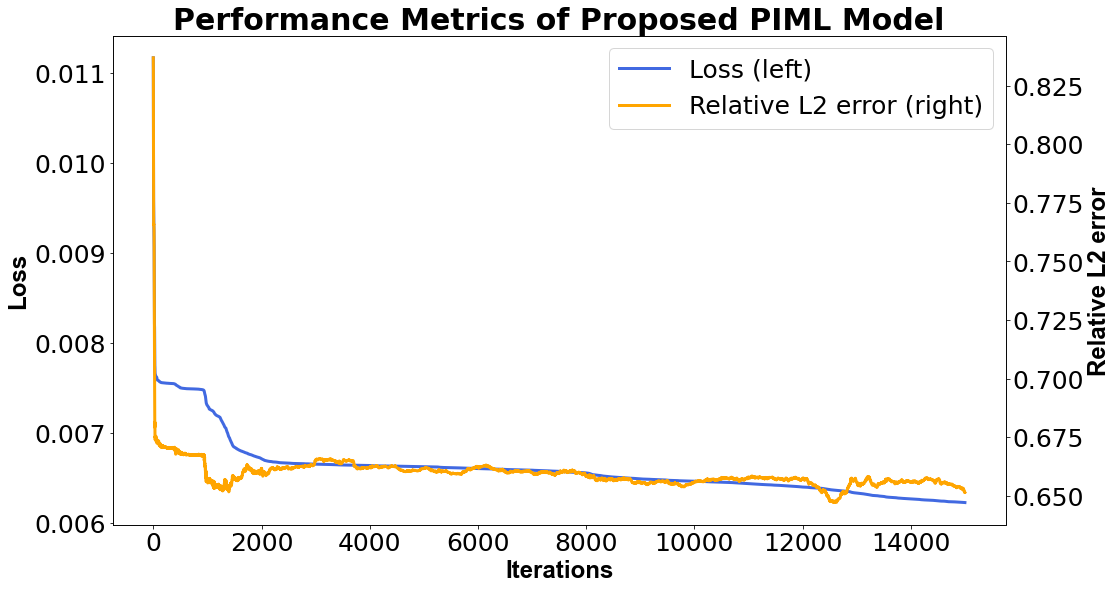

In [19]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [20]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.0369191669150364
MSE =  0.007377365542145838
RMSE =  0.08589159180121089
L2 relative error = 0.5737481604317901
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

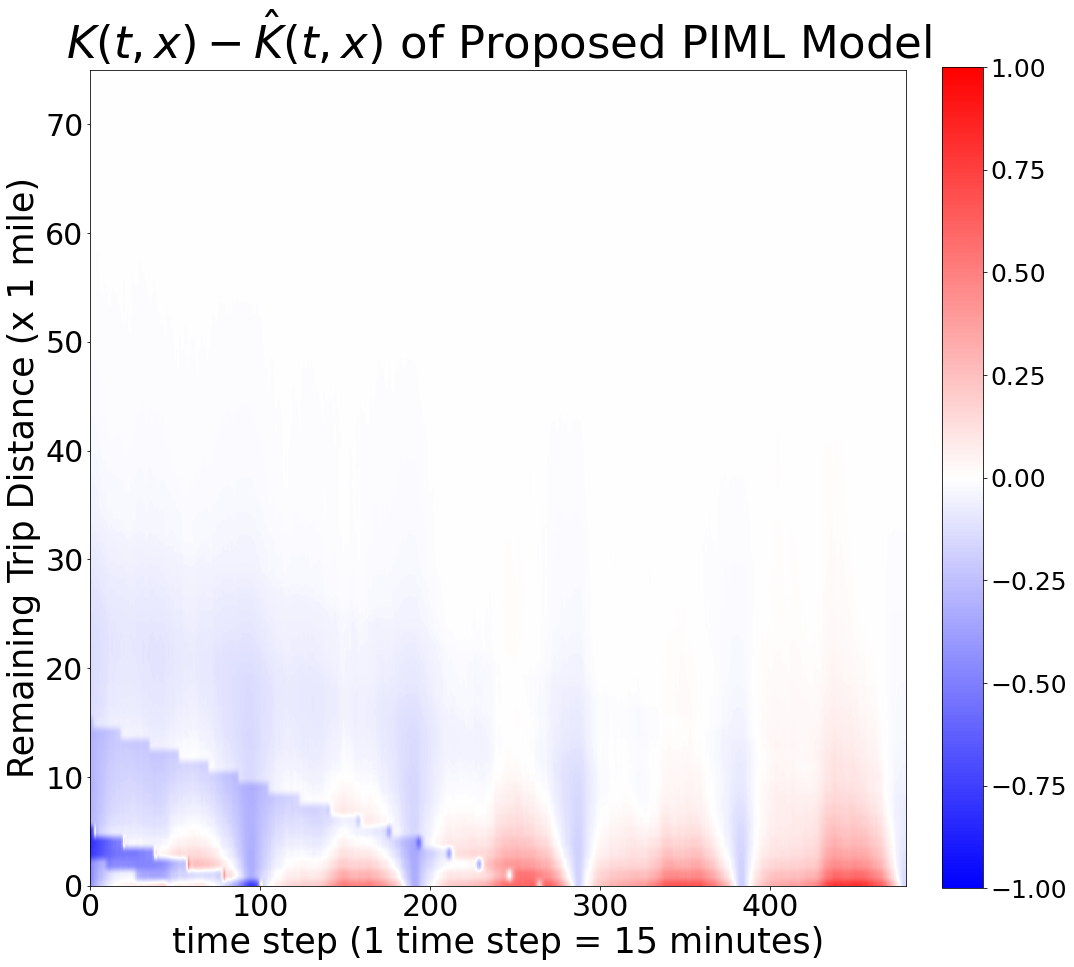

In [21]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,len(K_real),0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

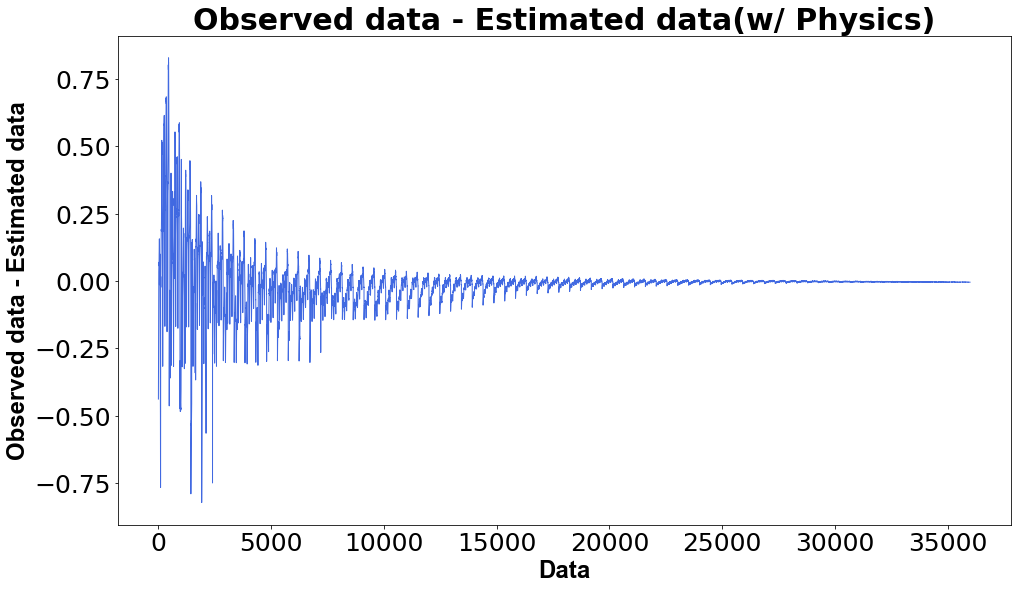

In [22]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

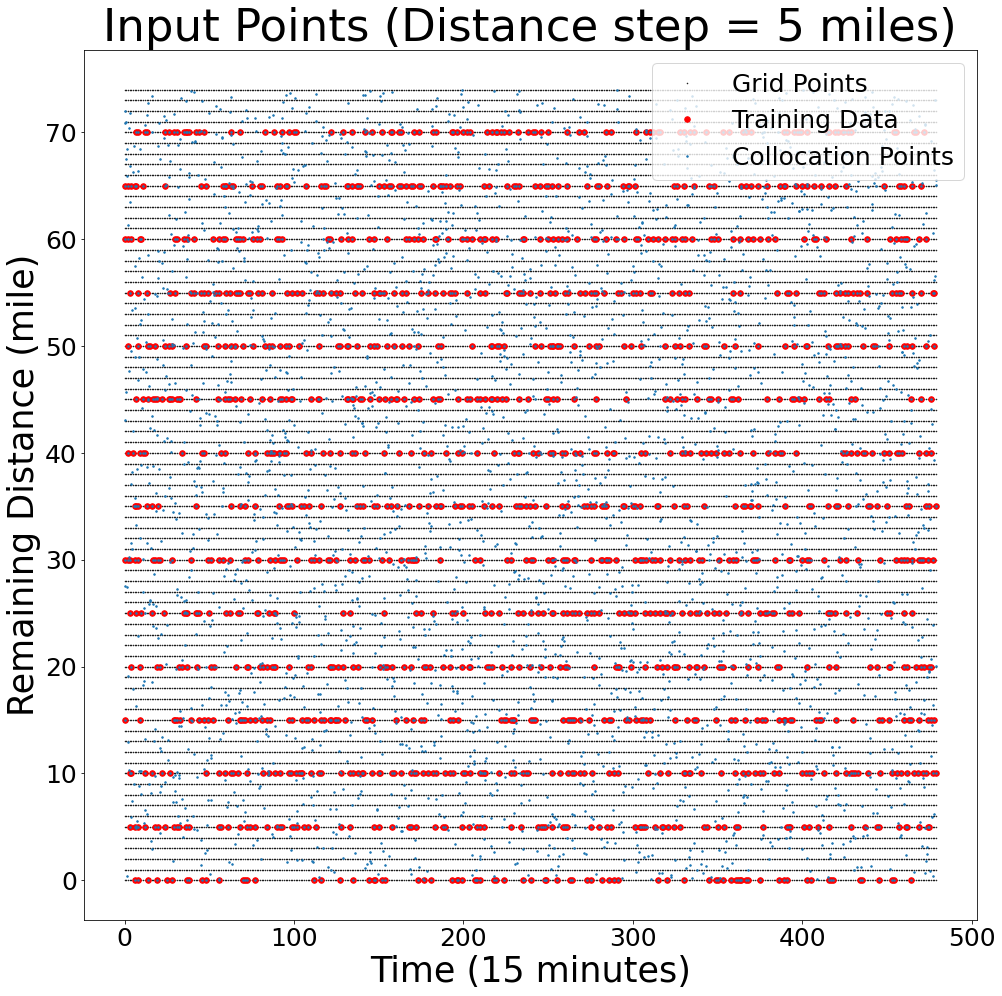

In [23]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

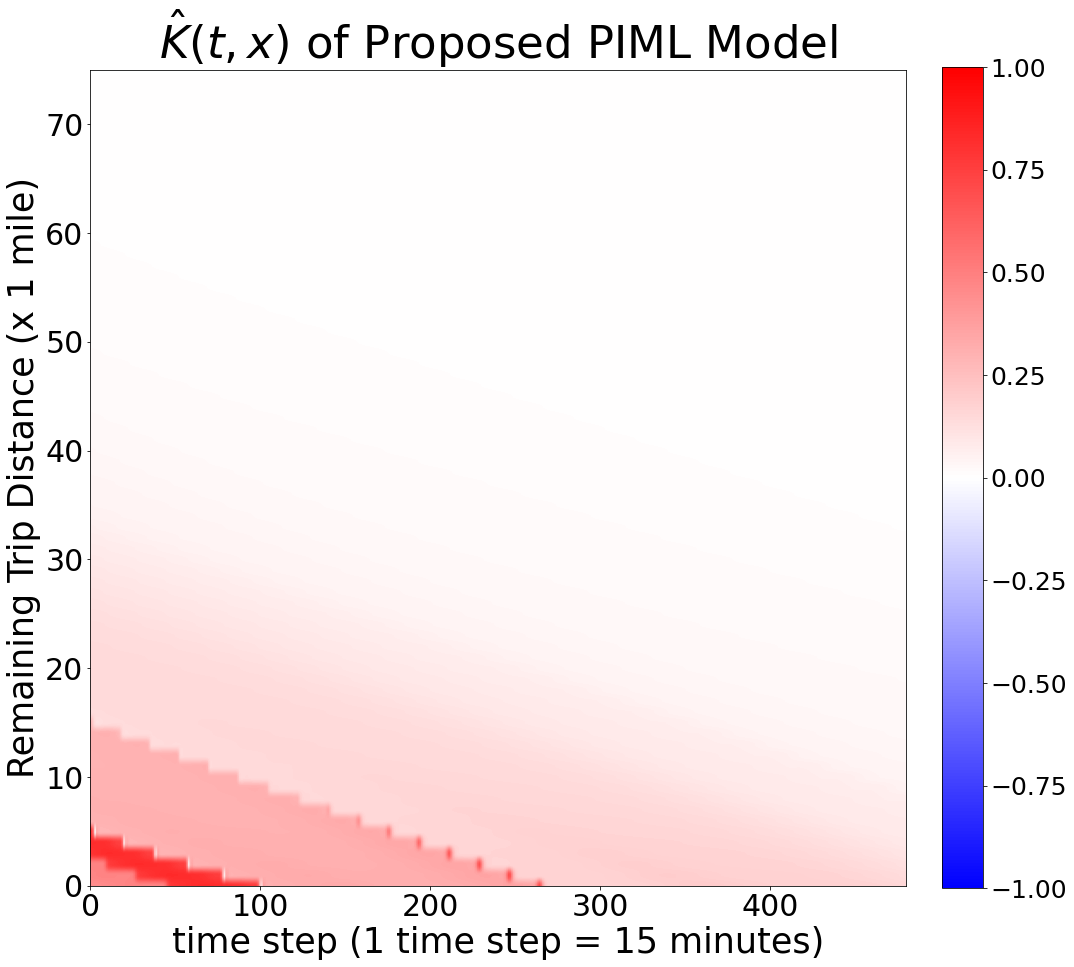

In [25]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,480,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)